In [1]:
import re
import os
import sys
import argparse
from copy import deepcopy
import do_mpc
import torch
import numpy as np
from matplotlib import pyplot as plt

from tianshou.policy import DSACPolicy, BasePolicy
from tianshou.env.venv_wrappers import MyVectorEnvNormObs
from tianshou.env.venvs import DummyVectorEnv, ShmemVectorEnv
from tianshou.data.buffer.vecbuf import ReplayBuffer, VectorReplayBuffer
from tianshou.env import SubprocVectorEnv
from tianshou.data import Collector, Batch, to_torch
from tianshou.data.types import RolloutBatchProtocol
from tianshou.utils.net.common import Net
from tianshou.utils.net.continuous import ActorProb, QuantileMlp

import numpy as np
from env.dompc_poly_env import DoMPC_Poly_env
from env.template_model import template_model
from env.template_mpc import template_mpc
from env.template_simulator import template_simulator

/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:regi

In [2]:
# set matplotlib fontsize
plt.rcParams.update({'font.size': 8})

In [3]:
env = DoMPC_Poly_env(hard_constraint=False, penalties=[], randomize=False)

Penalties added: []
Hard constraint: False
Ep length: 1000
Randomize init?: False


In [4]:
device = "cuda:3"
seed = 123
np.random.seed(seed);
torch.manual_seed(seed);

In [5]:
target_entropy = -np.prod(env.action_space.shape)
log_alpha = torch.tensor([np.log(0.1)], requires_grad=True, device=device)
alpha_optim = torch.optim.Adam([log_alpha], lr=0.0003)
alpha = (target_entropy, log_alpha, alpha_optim)

def get_dsac_args():
    args = argparse.Namespace(
        task="DoMPC",
        risk_type="neutral",
        buffer_size=1000000,
        hidden_sizes=[256, 256, 256],
        actor_lr=1e-4,
        critic_lr=3e-4,
        gamma=0.99,
        tau=0.005,
        alpha=alpha,
        alpha_lr=0.0003,
        start_timesteps=1,
        epoch=200,
        step_per_epoch=5000,
        step_per_collect=1,
        update_per_step=1,
        batch_size=256,
        training_num=1,
        test_num=10,
        distortion_param=0.75,
    )
    return args

In [6]:
def load_policy(path, alpha=0.065, auto_alpha=True):
    args = get_dsac_args()
    args.state_shape = env.observation_space.shape or env.observation_space.n
    args.action_shape = env.action_space.shape or env.action_space.n
    # model
    net_a = Net(args.state_shape, hidden_sizes=args.hidden_sizes, device=device)
    actor = ActorProb(
        net_a,
        args.action_shape,
        device=device,
        unbounded=True,
        conditioned_sigma=True,
    ).to(device)
    actor_optim = torch.optim.Adam(actor.parameters(), lr=args.actor_lr)
    critic1 = QuantileMlp(hidden_sizes=args.hidden_sizes, input_size=args.state_shape[0] + args.action_shape[0], device=device).to(device)
    critic1_optim = torch.optim.Adam(critic1.parameters(), lr=args.critic_lr)
    critic2 = QuantileMlp(hidden_sizes=args.hidden_sizes, input_size=args.state_shape[0] + args.action_shape[0], device=device).to(device)
    critic2_optim = torch.optim.Adam(critic2.parameters(), lr=args.critic_lr)
    if auto_alpha:
        target_entropy = -np.prod(env.action_space.shape)
        log_alpha = torch.tensor([np.log(alpha)], requires_grad=True, device=device)
        alpha_optim = torch.optim.Adam([log_alpha], lr=args.alpha_lr)
        args.alpha = (target_entropy, log_alpha, alpha_optim)
    else:
        args.alpha = alpha
    policy = DSACPolicy(
        actor,
        actor_optim,
        critic1,
        critic1_optim,
        critic2,
        critic2_optim,
        risk_type=args.risk_type,
        tau=args.tau,
        gamma=args.gamma,
        alpha=args.alpha,
        action_space=env.action_space,
        device=device,
        distortion_param=args.distortion_param,
        action_scaling=True,
    )
    dirname = os.path.dirname(path)
    if os.path.isfile(os.path.join(dirname, "actor.pth")):
        policy.actor.load_state_dict(torch.load(os.path.join(dirname, "actor.pth"), map_location=device))
        print("Loaded actor from: ", os.path.join(dirname, "actor.pth"))
    if os.path.isfile(os.path.join(dirname, "critic1.pth")):
        policy.critic1.load_state_dict(torch.load(os.path.join(dirname, "critic1.pth"), map_location=device))
        policy.critic1_old.load_state_dict(torch.load(os.path.join(dirname, "critic1.pth"), map_location=device))
        print("Loaded critic1 from: ", os.path.join(dirname, "critic1.pth"))
    if os.path.isfile(os.path.join(dirname, "critic2.pth")):
        policy.critic2.load_state_dict(torch.load(os.path.join(dirname, "critic2.pth"), map_location=device))
        policy.critic2_old.load_state_dict(torch.load(os.path.join(dirname, "critic2.pth"), map_location=device))
        print("Loaded critic2 from: ", os.path.join(dirname, "critic2.pth"))
    else:
        policy.load_state_dict(torch.load(path, map_location=device))
        print("Loaded agent from: ", path)
    return policy

In [7]:
venv = MyVectorEnvNormObs(DummyVectorEnv([lambda: env]))

In [8]:
expert_policy = load_policy("/data/user/R901105/dev/log/DoMPC/dsac/neutral/0/240305-161650/policy.pth")

Loaded agent from:  /data/user/R901105/dev/log/DoMPC/dsac/neutral/0/240305-161650/policy.pth


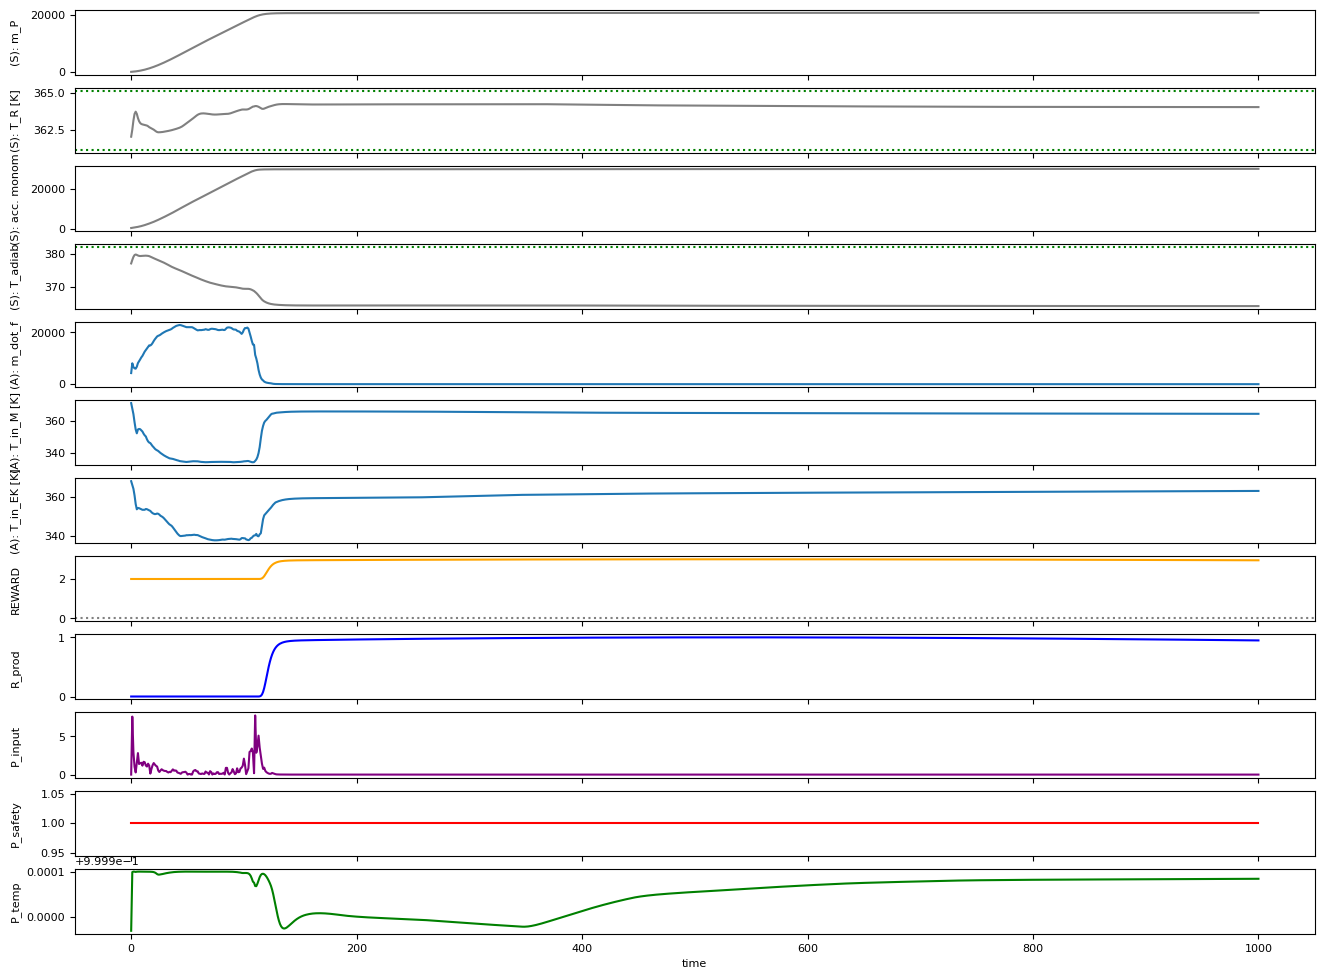

[None]

In [9]:
expert_policy.eval()
obs, info = venv.reset()
reward_list = []
observation_list = []
terminated = False
truncated = False
while not (terminated or truncated):
    observation_list.append(obs)
    batch = Batch(obs=torch.from_numpy(obs).to(device), info=info)
    with torch.no_grad():
        result = expert_policy(batch)
    act = result.act.cpu().numpy()
    act = expert_policy.map_action(act)
    observation, reward, terminated, truncated, info  = venv.step(act)
    obs = observation
    
    reward_list.append(reward)
venv.render()

In [10]:
sum(reward_list)

array([2863.70144361])

In [15]:
base_policy = load_policy("/data/user/R901105/dev/log/DoMPC/dsac/neutral/0/240311-131241/policy_10.pth", alpha=0.11, auto_alpha=True)

Loaded agent from:  /data/user/R901105/dev/log/DoMPC/dsac/neutral/0/240311-131241/policy_10.pth


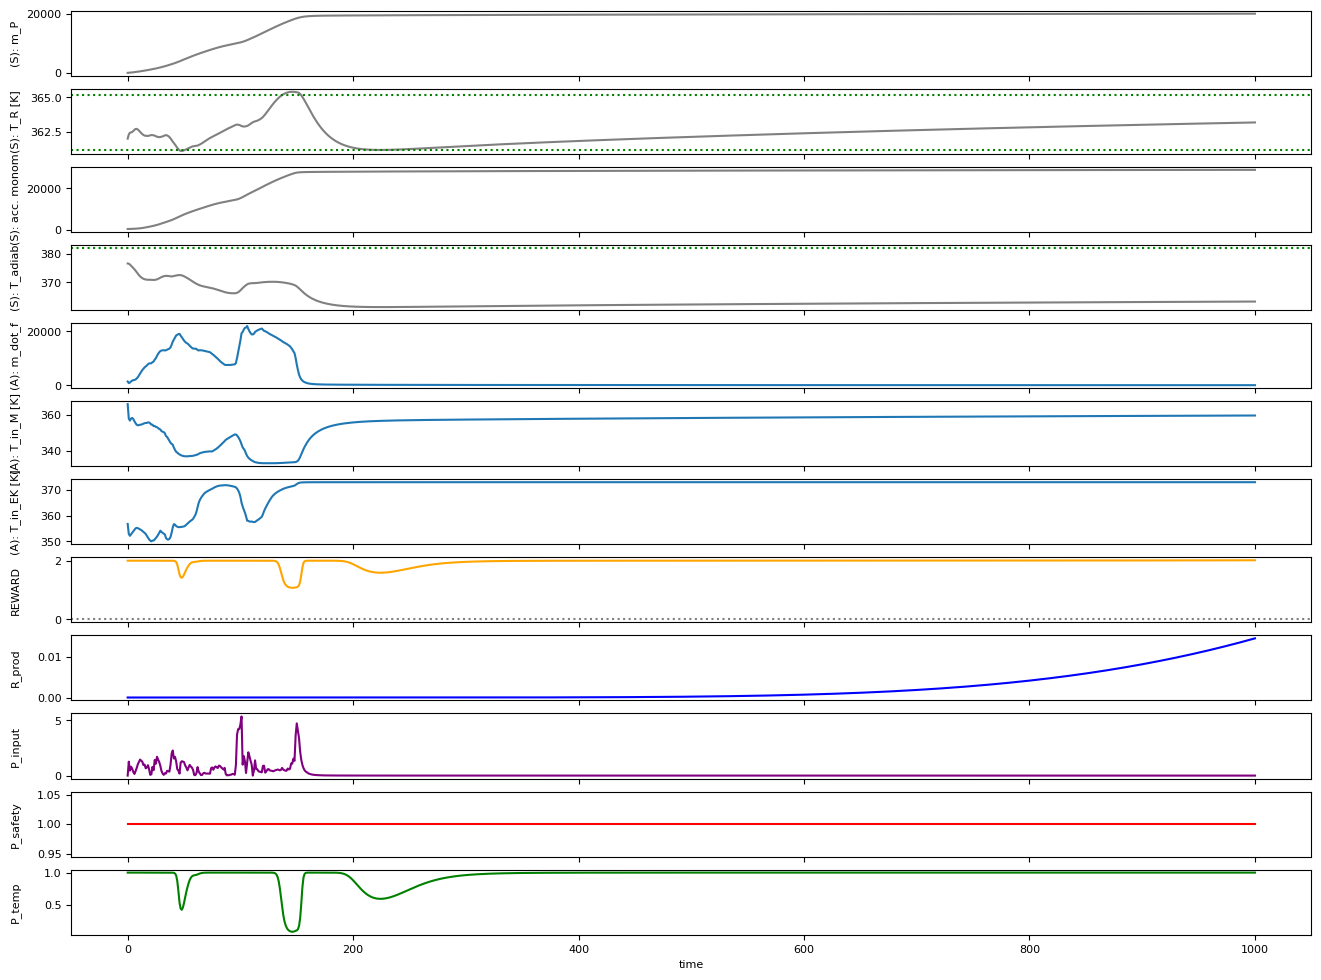

[None]

In [16]:
base_policy.eval()
obs, info = venv.reset()
reward_list = []
observation_list = []
terminated = False
truncated = False
while not (terminated or truncated):
    observation_list.append(obs)
    batch = Batch(obs=torch.from_numpy(obs).to(device), info=info)
    with torch.no_grad():
        result = base_policy(batch)
    act = result.act.cpu().numpy()
    act = base_policy.map_action(act)
    observation, reward, terminated, truncated, info  = venv.step(act)
    obs = observation
    
    reward_list.append(reward)
venv.render()

In [17]:
sum(reward_list)

array([1959.21624703])

In [18]:
class MixedPolicy(BasePolicy):
    def __init__(self, base_policy: BasePolicy, expert_policy: BasePolicy, action_space):
        super().__init__(action_space=action_space, action_scaling=True)
        self.base_policy = base_policy
        self.expert_policy = expert_policy
        self.cede_ctrl_prob = 1

    def forward(self, batch: RolloutBatchProtocol, state=None, n_repeat=100, **kwargs):
        bsz = len(batch.obs)
        batch = to_torch(batch, dtype=torch.float32, device=device)
        self.base_policy.eval()
        self.expert_policy.eval()
        with torch.no_grad():
            expert_result = self.expert_policy(batch)
            base_result = self.base_policy(batch)
            expert_qvalues1 = self.expert_policy.critic1(batch.obs, expert_result.act)
            expert_qvalues2 = self.expert_policy.critic2(batch.obs, expert_result.act)
            expert_qvalues = torch.minimum(expert_qvalues1, expert_qvalues2)
            base_qvalues1 = self.base_policy.critic1(batch.obs, base_result.act)
            base_qvalues2 = self.base_policy.critic2(batch.obs, base_result.act)
            base_qvalues = torch.minimum(base_qvalues1, base_qvalues2)
        cede_ctrl = base_qvalues[:, 0] < expert_qvalues[:, 0] 
        if bsz == 1:
            not_cede_ctrl = ~cede_ctrl * (torch.rand(1, device=device) >= self.cede_ctrl_prob)
            cede_ctrl = ~not_cede_ctrl
        # novel = torch.zeros_like(risky)
        cede_ctrl = cede_ctrl.unsqueeze(-1)
        actions = torch.where(cede_ctrl, expert_result.act.mean(0), base_result.act.mean(0))
        self.cede_ctrl_prob *= 0.99999
        return Batch(**{'act': actions, 'policy': Batch({'cede_ctrl': cede_ctrl})})

    def train(self, mode: bool = True) -> "MixedPolicy":
        self.base_policy.train(mode)
        return self
    
    def process_fn(self, batch: RolloutBatchProtocol, buffer: ReplayBuffer, indices: np.ndarray) -> RolloutBatchProtocol:
        return self.base_policy.process_fn(batch, buffer, indices)

    def learn(self, batch, **kwargs):
        # cede_ctrl = batch.policy.cede_ctrl.cpu().squeeze()
        # batch = batch[~cede_ctrl]
        info = self.base_policy.learn(batch)
        return info

In [15]:
mixed_policy = MixedPolicy(base_policy, expert_policy, env.action_space)

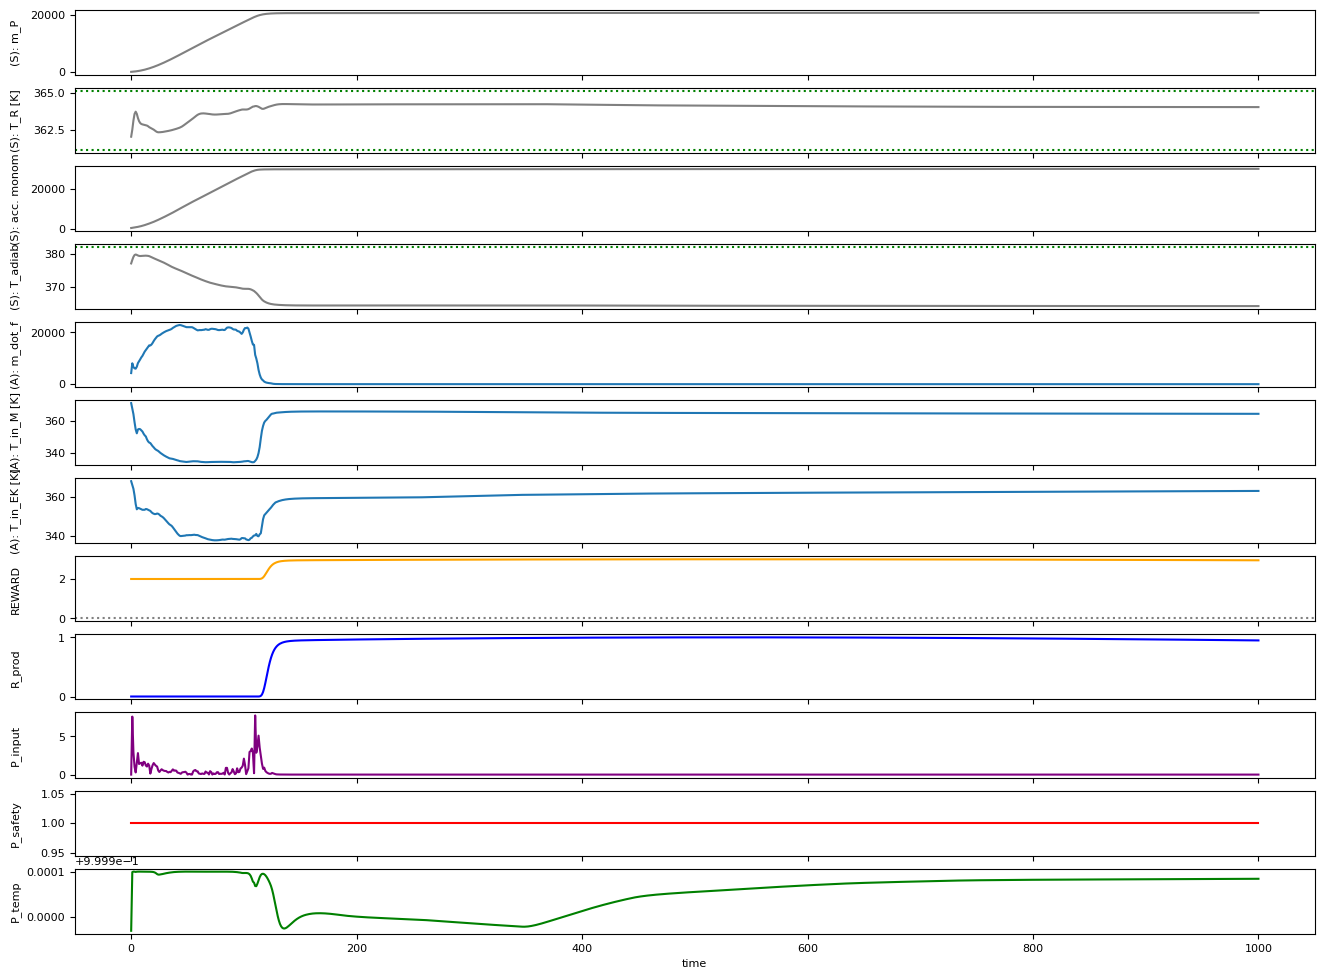

[None]

In [17]:
mixed_policy.eval()
obs, info = venv.reset()
reward_list = []
observation_list = []
terminated = False
truncated = False
while not (terminated or truncated):
    observation_list.append(obs)
    batch = Batch(obs=torch.from_numpy(obs).to(device), info=info)
    with torch.no_grad():
        result = mixed_policy(batch)
    act = result.act.cpu().numpy()
    act = base_policy.map_action(act)
    observation, reward, terminated, truncated, info  = venv.step(act)
    obs = observation
    
    reward_list.append(reward)
venv.render()

In [19]:
replay_buffer = VectorReplayBuffer(1000000, 1)
replay_buffer = replay_buffer.load_hdf5("/data/user/R901105/dev/log/DoMPC/dsac/neutral/0/240311-131241/buffer.hdf5")

In [20]:
import datetime
from torch.utils.tensorboard import SummaryWriter
from tianshou.utils import TensorboardLogger
# log
now = datetime.datetime.now().strftime("%y%m%d-%H%M%S")
log_name = os.path.join("DoMPC", "base", now)
log_path = os.path.join("../../log", log_name)
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

In [21]:
train_envs = MyVectorEnvNormObs(ShmemVectorEnv([lambda: DoMPC_Poly_env(hard_constraint=False, penalties=[], randomize=False) for _ in range(1)]))
test_envs = MyVectorEnvNormObs(ShmemVectorEnv([lambda: DoMPC_Poly_env(hard_constraint=False, penalties=[], randomize=False) for _ in range(10)]))

Penalties added: []
Hard constraint: False
Ep length: 1000
Randomize init?: False


Penalties added: []
Hard constraint: False
Ep length: 1000
Randomize init?: False
Penalties added: []
Hard constraint: False
Ep length: 1000
Randomize init?: False
Penalties added: []
Hard constraint: False
Ep length: 1000
Randomize init?: False
Penalties added: []
Hard constraint: False
Ep length: 1000
Randomize init?: False
Penalties added: []
Hard constraint: False
Ep length: 1000
Randomize init?: False
Penalties added: []
Hard constraint: False
Ep length: 1000
Randomize init?: False
Penalties added: []
Hard constraint: False
Ep length: 1000
Randomize init?: False
Penalties added: []
Hard constraint: False
Ep length: 1000
Randomize init?: False
Penalties added: []
Hard constraint: False
Ep length: 1000
Randomize init?: False
Penalties added: []
Hard constraint: False
Ep length: 1000
Randomize init?: False
Penalties added: []
Hard constraint: False
Ep length: 1000
Randomize init?: False
Penalties added: []
Hard constraint: False
Ep length: 1000
Randomize init?: False
Penalties added:

In [22]:
test_buffer = VectorReplayBuffer(1001*10, 10)
train_collector = Collector(base_policy, train_envs, replay_buffer)
test_collector = Collector(base_policy, test_envs, test_buffer)

In [23]:
def get_return(policy, return_cede_ctrl=False):
    policy.eval()
    obs, info = venv.reset()
    reward_list = []
    cede_ctrl_list = []
    terminated = False
    truncated = False
    while not (terminated or truncated):
        batch = Batch(obs=torch.from_numpy(obs).to(device), info=info)
        with torch.no_grad():
            result = policy(batch)
        if return_cede_ctrl:
            cede_ctrl_list.append(result.policy.cede_ctrl.cpu().numpy())
        act = result.act.cpu().numpy()
        act = policy.map_action(act)
        observation, reward, terminated, truncated, info  = venv.step(act)
        obs = observation
        reward_list.append(reward)
    if return_cede_ctrl:
        return sum(reward_list), sum(cede_ctrl_list)/len(cede_ctrl_list)
    return sum(reward_list)

In [23]:
expert_return = get_return(expert_policy)
def test_fn(num_epoch: int, step_idx: int):
    mixed_return, cede_ctrl = get_return(mixed_policy, return_cede_ctrl=True)
    base_policy_return = get_return(base_policy)
    writer.add_scalar("return/expert", expert_return, step_idx)
    writer.add_scalar("return/mixed", mixed_return, step_idx)
    writer.add_scalar("return/base", base_policy_return, step_idx)
    writer.add_scalar("cede_ctrl", cede_ctrl, step_idx)

In [24]:
from tianshou.trainer import OffpolicyTrainer

result = OffpolicyTrainer(
    policy=base_policy,
    train_collector=train_collector,
    test_collector=test_collector,
    # test_fn=test_fn,
    max_epoch=200,
    step_per_epoch=1001,
    step_per_collect=1,
    episode_per_test=1,
    batch_size=256,
    logger=logger,
    update_per_step=1,
    test_in_train=False,
).run()

Epoch #1: 1002it [00:24, 41.18it/s, alpha=0.073, env_step=1001, gradient_step=1001, len=1892, loss/actor=-165.703, loss/alpha=0.457, loss/critic1=0.408, loss/critic2=0.428, n/ep=1, n/st=1, rew=3271.92]                          


Epoch #1: test_reward: 1304.889443 ± 0.000000, best_reward: 1959.216247 ± 0.000000 in #0


Epoch #2: 1002it [00:23, 42.45it/s, alpha=0.075, env_step=2002, gradient_step=2002, len=1001, loss/actor=-165.719, loss/alpha=0.265, loss/critic1=0.397, loss/critic2=0.409, n/ep=1, n/st=1, rew=1259.85]                          


Epoch #2: test_reward: 1368.328554 ± 0.000000, best_reward: 1959.216247 ± 0.000000 in #0


Epoch #3: 1002it [00:22, 44.60it/s, alpha=0.080, env_step=3003, gradient_step=3003, len=1001, loss/actor=-165.256, loss/alpha=0.509, loss/critic1=0.382, loss/critic2=0.418, n/ep=1, n/st=1, rew=1462.51]                          


Epoch #3: test_reward: 1295.107063 ± 0.000000, best_reward: 1959.216247 ± 0.000000 in #0


Epoch #4: 1002it [00:22, 44.80it/s, alpha=0.089, env_step=4004, gradient_step=4004, len=1001, loss/actor=-164.926, loss/alpha=0.321, loss/critic1=0.390, loss/critic2=0.390, n/ep=1, n/st=1, rew=1644.16]                          


Epoch #4: test_reward: 1439.088744 ± 0.000000, best_reward: 1959.216247 ± 0.000000 in #0


Epoch #5: 1002it [00:22, 44.68it/s, alpha=0.097, env_step=5005, gradient_step=5005, len=1001, loss/actor=-164.264, loss/alpha=0.159, loss/critic1=0.404, loss/critic2=0.391, n/ep=1, n/st=1, rew=1861.22]                          


Epoch #5: test_reward: 1517.530740 ± 0.000000, best_reward: 1959.216247 ± 0.000000 in #0


Epoch #6: 1002it [00:22, 44.92it/s, alpha=0.103, env_step=6006, gradient_step=6006, len=1001, loss/actor=-163.073, loss/alpha=0.103, loss/critic1=0.407, loss/critic2=0.434, n/ep=1, n/st=1, rew=1862.79]                          


Epoch #6: test_reward: 2453.887014 ± 0.000000, best_reward: 2453.887014 ± 0.000000 in #6


Epoch #7: 1002it [00:22, 44.70it/s, alpha=0.107, env_step=7007, gradient_step=7007, len=1001, loss/actor=-162.733, loss/alpha=0.101, loss/critic1=0.433, loss/critic2=0.444, n/ep=1, n/st=1, rew=1920.39]                          


Epoch #7: test_reward: 1583.080890 ± 0.000000, best_reward: 2453.887014 ± 0.000000 in #6


Epoch #8: 1002it [00:22, 44.87it/s, alpha=0.110, env_step=8008, gradient_step=8008, len=1001, loss/actor=-161.988, loss/alpha=0.119, loss/critic1=0.431, loss/critic2=0.447, n/ep=1, n/st=1, rew=1919.48]                          


Epoch #8: test_reward: 1685.256292 ± 0.000000, best_reward: 2453.887014 ± 0.000000 in #6


Epoch #9: 1002it [00:22, 44.98it/s, alpha=0.110, env_step=9009, gradient_step=9009, len=1001, loss/actor=-160.910, loss/alpha=0.181, loss/critic1=0.417, loss/critic2=0.454, n/ep=1, n/st=1, rew=1970.85]                          


Epoch #9: test_reward: 1725.959617 ± 0.000000, best_reward: 2453.887014 ± 0.000000 in #6


Epoch #10: 1002it [00:22, 44.91it/s, alpha=0.112, env_step=10010, gradient_step=10010, len=1001, loss/actor=-159.865, loss/alpha=0.093, loss/critic1=0.452, loss/critic2=0.499, n/ep=1, n/st=1, rew=1927.97]                          


Epoch #10: test_reward: 2113.738689 ± 0.000000, best_reward: 2453.887014 ± 0.000000 in #6


Epoch #11: 1002it [00:22, 44.92it/s, alpha=0.112, env_step=11011, gradient_step=11011, len=1001, loss/actor=-159.459, loss/alpha=-0.006, loss/critic1=0.456, loss/critic2=0.438, n/ep=1, n/st=1, rew=2005.99]                          


Epoch #11: test_reward: 2360.433542 ± 0.000000, best_reward: 2453.887014 ± 0.000000 in #6


Epoch #12: 1002it [00:22, 44.97it/s, alpha=0.111, env_step=12012, gradient_step=12012, len=1001, loss/actor=-158.569, loss/alpha=-0.033, loss/critic1=0.461, loss/critic2=0.429, n/ep=1, n/st=1, rew=1844.40]                          


Epoch #12: test_reward: 1709.588645 ± 0.000000, best_reward: 2453.887014 ± 0.000000 in #6


Epoch #13: 1002it [00:22, 45.08it/s, alpha=0.110, env_step=13013, gradient_step=13013, len=1001, loss/actor=-158.171, loss/alpha=-0.138, loss/critic1=0.411, loss/critic2=0.394, n/ep=1, n/st=1, rew=2107.43]                          


Epoch #13: test_reward: 2296.755089 ± 0.000000, best_reward: 2453.887014 ± 0.000000 in #6


Epoch #14: 1002it [00:22, 44.99it/s, alpha=0.108, env_step=14014, gradient_step=14014, len=1001, loss/actor=-157.863, loss/alpha=-0.215, loss/critic1=0.417, loss/critic2=0.414, n/ep=1, n/st=1, rew=1971.75]                          


Epoch #14: test_reward: 1952.622716 ± 0.000000, best_reward: 2453.887014 ± 0.000000 in #6


Epoch #15: 1002it [00:22, 44.60it/s, alpha=0.106, env_step=15015, gradient_step=15015, len=1001, loss/actor=-156.935, loss/alpha=0.037, loss/critic1=0.428, loss/critic2=0.443, n/ep=1, n/st=1, rew=2138.01]                          


Epoch #15: test_reward: 1733.535502 ± 0.000000, best_reward: 2453.887014 ± 0.000000 in #6


Epoch #16: 1002it [00:22, 44.71it/s, alpha=0.102, env_step=16016, gradient_step=16016, len=1001, loss/actor=-156.293, loss/alpha=-0.017, loss/critic1=0.380, loss/critic2=0.395, n/ep=1, n/st=1, rew=2030.16]                          


Epoch #16: test_reward: 1885.351688 ± 0.000000, best_reward: 2453.887014 ± 0.000000 in #6


Epoch #17: 1002it [00:22, 44.65it/s, alpha=0.100, env_step=17017, gradient_step=17017, len=1001, loss/actor=-155.870, loss/alpha=0.374, loss/critic1=0.384, loss/critic2=0.395, n/ep=1, n/st=1, rew=2015.15]                          


Epoch #17: test_reward: 2225.231107 ± 0.000000, best_reward: 2453.887014 ± 0.000000 in #6


Epoch #18: 1002it [00:22, 44.80it/s, alpha=0.098, env_step=18018, gradient_step=18018, len=1001, loss/actor=-155.490, loss/alpha=-0.054, loss/critic1=0.384, loss/critic2=0.365, n/ep=1, n/st=1, rew=1957.70]                          


Epoch #18: test_reward: 2024.137345 ± 0.000000, best_reward: 2453.887014 ± 0.000000 in #6


Epoch #19: 1002it [00:22, 44.62it/s, alpha=0.092, env_step=19019, gradient_step=19019, len=1001, loss/actor=-155.119, loss/alpha=0.074, loss/critic1=0.365, loss/critic2=0.389, n/ep=1, n/st=1, rew=2057.64]                          


Epoch #19: test_reward: 2354.706855 ± 0.000000, best_reward: 2453.887014 ± 0.000000 in #6


Epoch #20:  18%|#7        | 180/1001 [00:04<00:18, 43.58it/s, alpha=0.092, env_step=19199, gradient_step=19199, len=1001, loss/actor=-155.413, loss/alpha=-0.068, loss/critic1=0.352, loss/critic2=0.351, n/ep=0, n/st=1, rew=2057.64]

In [35]:
len(replay_buffer)

1000000

In [ ]:
np.finfo(np.float32).eps.item()

1.1920928955078125e-07

In [ ]:
class suppress_print:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [ ]:
def construct_state_dict(x0):
    if isinstance(x0, dict):
        state_dict = {
            'm_W': x0['m_W'],
            'm_A': x0['m_A'],
            'm_P': x0['m_P'],
            'T_R': x0['T_R'],
            'T_S': x0['T_S'],
            'Tout_M': x0['Tout_M'],
            'T_EK': x0['T_EK'],
            'Tout_AWT': x0['Tout_AWT'],
            'accum_monom': x0['accum_monom'],
        }
    elif isinstance(x0, np.ndarray):
        state_dict = {
            'm_W': x0[:, 0],
            'm_A': x0[:, 1],
            'm_P': x0[:, 2],
            'T_R': x0[:, 3],
            'T_S': x0[:, 4],
            'Tout_M': x0[:, 5],
            'T_EK': x0[:, 6],
            'Tout_AWT': x0[:, 7],
            'accum_monom': x0[:, 8],
        }
    else:
        raise ValueError("x0 is not a recognized type")
    return state_dict

def policy_rollout(expert_policy, base_policy, init_state, length=10):
    with suppress_print():
        _venv = MyVectorEnvNormObs(SubprocVectorEnv([lambda: DoMPC_Poly_env(hard_constraint=False, penalties=[], randomize=False) for _ in range(2)]))
    expert_policy.eval()
    base_policy.eval()
    obs, info = _venv.reset(init_state=init_state)
    states = []
    for i in range(length):
        states.append(_venv.denormalize_obs(obs).squeeze())
        expert_batch = Batch(obs=torch.from_numpy(obs[0]).reshape((1, -1)).to(device), info=info)
        base_batch = Batch(obs=torch.from_numpy(obs[1]).reshape((1, -1)).to(device), info=info)
        with torch.no_grad():
            expert_result = expert_policy(expert_batch)
            base_result = base_policy(base_batch)
        expert_act = expert_result.act.cpu().numpy()
        expert_act = expert_policy.map_action(expert_act)
        base_act = base_result.act.cpu().numpy()
        base_act = base_policy.map_action(base_act)
        observation, _, _, _, info  = _venv.step(np.concatenate([expert_act, base_act]))
        obs = observation
        if i == 0:
            expert_action = expert_act
            base_action = base_act
    expert_states = np.array(states)[:, 0, :]
    base_states = np.array(states)[:, 1, :]
    return expert_states, base_states, expert_action, base_action

def check_constraints(states):
    return all(abs(states[:, 3] - env.desired_temp) <= 2) and all(states[:, -1] <= 382.15)

def get_act(state, expert_policy, base_policy, length=1):
    expert_states, base_states, expert_action, base_action = policy_rollout(expert_policy, base_policy, state, length=length)

    if check_constraints(base_states):
        if abs(base_states[-1, 2] - 20680) < abs(expert_states[-1, 2] - 20680) - 50:
            return base_action, [False]
    
    return expert_action, [True]

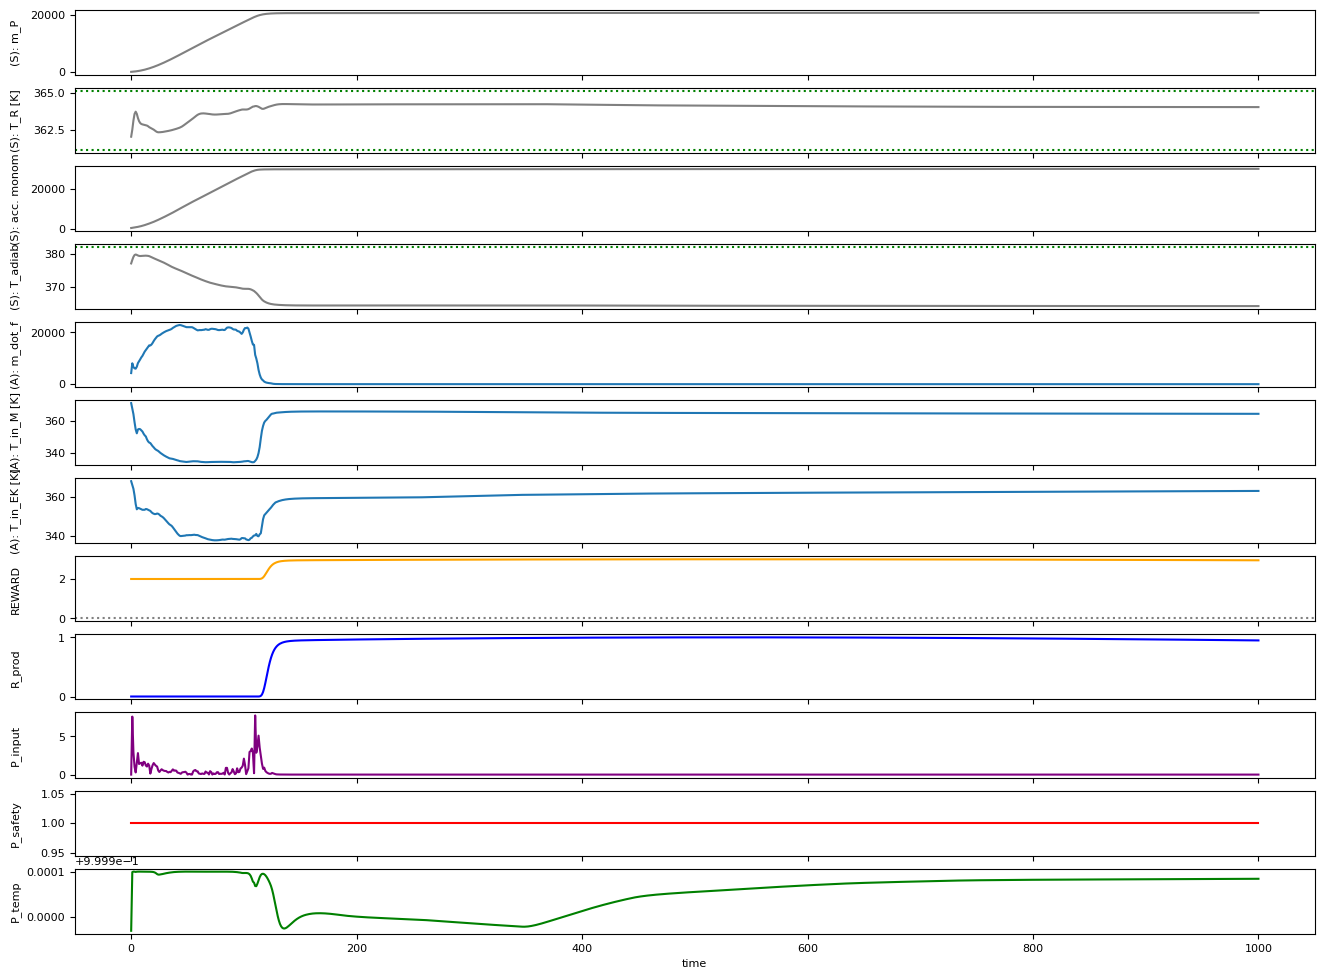

[None]

In [ ]:
obs, info = venv.reset()
reward_list = []
observation_list = []
terminated = False
truncated = False
while not (terminated or truncated):
    observation_list.append(obs)
    state = venv.denormalize_obs(obs)
    act, cede_ctrl = get_act(state, expert_policy, base_policy)
    observation, reward, terminated, truncated, info  = venv.step(act)
    obs = observation
    
    reward_list.append(reward)
venv.render()

In [ ]:
class MixedPolicy(BasePolicy):
    def __init__(self, base_policy: BasePolicy, expert_policy: BasePolicy, action_space):
        super().__init__(action_space=action_space, action_scaling=False)
        self.base_policy = base_policy
        self.expert_policy = expert_policy

    def forward(self, batch: RolloutBatchProtocol, state=None, **kwargs):
        obs = batch.obs
        state = venv.denormalize_obs(obs.cpu().numpy() if isinstance(obs, torch.Tensor) else obs)
        action, cede_ctrl = get_act(state, expert_policy, base_policy)
        return Batch(**{'act': to_torch(action, device=device), 'policy': Batch({'cede_ctrl': to_torch(cede_ctrl, device=device, dtype=torch.bool)})})

    def train(self, mode: bool = True) -> "MixedPolicy":
        self.base_policy.train(mode)
        return self
    
    def process_fn(self, batch: RolloutBatchProtocol, buffer: ReplayBuffer, indices: np.ndarray) -> RolloutBatchProtocol:
        return self.base_policy.process_fn(batch, buffer, indices)

    def learn(self, batch, **kwargs):
        cede_ctrl = batch.policy.cede_ctrl.cpu().squeeze()
        batch = batch[~cede_ctrl]
        info = self.base_policy.learn(batch)
        return info

In [ ]:
import datetime
from torch.utils.tensorboard import SummaryWriter
from tianshou.utils import TensorboardLogger
# log
now = datetime.datetime.now().strftime("%y%m%d-%H%M%S")
log_name = os.path.join("DoMPC", "base", now)
log_path = os.path.join("../../log", log_name)
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

In [ ]:
def get_return(policy, return_cede_ctrl=False):
    policy.eval()
    obs, info = venv.reset()
    reward_list = []
    cede_ctrl_list = []
    terminated = False
    truncated = False
    while not (terminated or truncated):
        batch = Batch(obs=torch.from_numpy(obs).to(device), info=info)
        with torch.no_grad():
            result = policy(batch)
        if return_cede_ctrl:
            cede_ctrl_list.append(result.policy.cede_ctrl.cpu().numpy())
        act = result.act.cpu().numpy()
        act = policy.map_action(act)
        observation, reward, terminated, truncated, info  = venv.step(act)
        obs = observation
        reward_list.append(reward)
    if return_cede_ctrl:
        return sum(reward_list), sum(cede_ctrl_list)/len(cede_ctrl_list)
    return sum(reward_list)

In [ ]:
mixed_policy = MixedPolicy(base_policy, expert_policy, env.action_space)

In [ ]:
train_envs = MyVectorEnvNormObs(ShmemVectorEnv([lambda: DoMPC_Poly_env(hard_constraint=False, penalties=[], randomize=False) for _ in range(1)]))
test_envs = MyVectorEnvNormObs(ShmemVectorEnv([lambda: DoMPC_Poly_env(hard_constraint=False, penalties=[], randomize=False) for _ in range(10)]))

In [ ]:
test_buffer = ReplayBuffer(5000)
train_buffer = ReplayBuffer(1000000)
train_buffer.load_hdf5("/data/user/R901105/dev/log/DoMPC/dsac/neutral/0/240311-103546/buffer.hdf5")
train_collector = Collector(mixed_policy, venv, train_buffer)
test_collector = Collector(mixed_policy, venv, test_buffer)

In [ ]:
# train_collector.collect(n_episode=1)

In [ ]:
# train_collector = Collector(mixed_policy, env, train_buffer)

In [ ]:
expert_return = get_return(expert_policy)
def test_fn(num_epoch: int, step_idx: int):
    mixed_return, cede_ctrl = get_return(mixed_policy, return_cede_ctrl=True)
    base_policy_return = get_return(base_policy)
    writer.add_scalar("return/expert", expert_return, step_idx)
    writer.add_scalar("return/mixed", mixed_return, step_idx)
    writer.add_scalar("return/base", base_policy_return, step_idx)
    writer.add_scalar("cede_ctrl", cede_ctrl, step_idx)

In [ ]:
from tianshou.trainer import OffpolicyTrainer

result = OffpolicyTrainer(
    policy=base_policy,
    train_collector=train_collector,
    test_collector=test_collector,
    test_fn=test_fn,
    max_epoch=200,
    step_per_epoch=500,
    step_per_collect=1,
    episode_per_test=1,
    batch_size=256,
    logger=logger,
    update_per_step=1,
    test_in_train=False,
).run()

Epoch #1: 501it [01:58,  4.22it/s, alpha=0.021, env_step=500, gradient_step=500, len=0, loss/actor=-122.433, loss/alpha=-35.524, loss/critic1=0.640, loss/critic2=0.655, n/ep=0, n/st=1, rew=0.00]                         


Epoch #1: test_reward: 1.000000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #0


Epoch #2: 501it [01:57,  4.28it/s, alpha=0.018, env_step=1000, gradient_step=1000, len=0, loss/actor=-121.253, loss/alpha=-37.763, loss/critic1=0.610, loss/critic2=0.616, n/ep=0, n/st=1, rew=0.00]                         


Epoch #2: test_reward: 1.000000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #0


Epoch #3: 501it [02:01,  4.11it/s, alpha=0.016, env_step=1500, gradient_step=1500, len=0, loss/actor=-120.427, loss/alpha=-39.453, loss/critic1=0.605, loss/critic2=0.603, n/ep=0, n/st=1, rew=0.00]                         


Epoch #3: test_reward: 1.000000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #0


Epoch #4: 501it [02:03,  4.07it/s, alpha=0.014, env_step=2000, gradient_step=2000, len=0, loss/actor=-119.772, loss/alpha=-40.463, loss/critic1=0.558, loss/critic2=0.558, n/ep=0, n/st=1, rew=0.00]                         


Epoch #4: test_reward: 1.000000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #4


Epoch #5: 501it [01:55,  4.35it/s, alpha=0.012, env_step=2500, gradient_step=2500, len=0, loss/actor=-119.801, loss/alpha=-41.270, loss/critic1=0.570, loss/critic2=0.585, n/ep=0, n/st=1, rew=0.00]                         


Epoch #5: test_reward: 1.000000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #4


Epoch #6: 501it [01:59,  4.21it/s, alpha=0.010, env_step=3000, gradient_step=3000, len=0, loss/actor=-119.160, loss/alpha=-39.795, loss/critic1=0.594, loss/critic2=0.588, n/ep=0, n/st=1, rew=0.00]                         


Epoch #6: test_reward: 1.000000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #4


Epoch #7: 501it [01:59,  4.19it/s, alpha=0.009, env_step=3500, gradient_step=3500, len=0, loss/actor=-118.620, loss/alpha=-30.097, loss/critic1=0.563, loss/critic2=0.563, n/ep=0, n/st=1, rew=0.00]                         


Epoch #7: test_reward: 1.000001 ± 0.000000, best_reward: 1.000001 ± 0.000000 in #7


Epoch #8: 501it [02:00,  4.16it/s, alpha=0.008, env_step=4000, gradient_step=4000, len=0, loss/actor=-118.282, loss/alpha=-28.878, loss/critic1=0.563, loss/critic2=0.560, n/ep=0, n/st=1, rew=0.00]                         


Epoch #8: test_reward: 1.000000 ± 0.000000, best_reward: 1.000001 ± 0.000000 in #7


Epoch #9: 501it [01:58,  4.22it/s, alpha=0.007, env_step=4500, gradient_step=4500, len=0, loss/actor=-118.006, loss/alpha=-28.193, loss/critic1=0.572, loss/critic2=0.570, n/ep=0, n/st=1, rew=0.00]                         


Epoch #9: test_reward: 1.000000 ± 0.000000, best_reward: 1.000001 ± 0.000000 in #7


Epoch #10: 501it [01:55,  4.34it/s, alpha=0.006, env_step=5000, gradient_step=5000, len=0, loss/actor=-117.864, loss/alpha=-27.821, loss/critic1=0.570, loss/critic2=0.564, n/ep=0, n/st=1, rew=0.00]                         


Epoch #10: test_reward: 1.000000 ± 0.000000, best_reward: 1.000001 ± 0.000000 in #7


Epoch #11: 501it [01:58,  4.21it/s, alpha=0.006, env_step=5500, gradient_step=5500, len=0, loss/actor=-117.574, loss/alpha=-26.140, loss/critic1=0.564, loss/critic2=0.560, n/ep=0, n/st=1, rew=0.00]                         


Epoch #11: test_reward: 1.000000 ± 0.000000, best_reward: 1.000001 ± 0.000000 in #7


Epoch #12: 501it [01:59,  4.21it/s, alpha=0.005, env_step=6000, gradient_step=6000, len=0, loss/actor=-117.202, loss/alpha=-25.173, loss/critic1=0.554, loss/critic2=0.553, n/ep=0, n/st=1, rew=0.00]                         


Epoch #12: test_reward: 1.000000 ± 0.000000, best_reward: 1.000001 ± 0.000000 in #7


Epoch #13: 501it [01:58,  4.22it/s, alpha=0.004, env_step=6500, gradient_step=6500, len=0, loss/actor=-117.000, loss/alpha=-24.481, loss/critic1=0.553, loss/critic2=0.534, n/ep=0, n/st=1, rew=0.00]                         


Epoch #13: test_reward: 1.000000 ± 0.000000, best_reward: 1.000001 ± 0.000000 in #7


Epoch #14: 501it [01:59,  4.19it/s, alpha=0.004, env_step=7000, gradient_step=7000, len=0, loss/actor=-116.846, loss/alpha=-23.938, loss/critic1=0.511, loss/critic2=0.501, n/ep=0, n/st=1, rew=0.00]                         


Epoch #14: test_reward: 1.000000 ± 0.000000, best_reward: 1.000001 ± 0.000000 in #7


Epoch #15: 501it [01:59,  4.20it/s, alpha=0.003, env_step=7500, gradient_step=7500, len=0, loss/actor=-116.522, loss/alpha=-23.069, loss/critic1=0.492, loss/critic2=0.490, n/ep=0, n/st=1, rew=0.00]                         


Epoch #15: test_reward: 1.000000 ± 0.000000, best_reward: 1.000001 ± 0.000000 in #7


Epoch #16: 501it [02:04,  4.02it/s, alpha=0.003, env_step=8000, gradient_step=8000, len=0, loss/actor=-116.583, loss/alpha=-22.393, loss/critic1=0.493, loss/critic2=0.483, n/ep=0, n/st=1, rew=0.00]                         


Epoch #16: test_reward: 1.000000 ± 0.000000, best_reward: 1.000001 ± 0.000000 in #7


Epoch #17: 501it [02:07,  3.94it/s, alpha=0.003, env_step=8500, gradient_step=8500, len=0, loss/actor=-116.456, loss/alpha=-21.024, loss/critic1=0.474, loss/critic2=0.465, n/ep=0, n/st=1, rew=0.00]                         


Epoch #17: test_reward: 1.000000 ± 0.000000, best_reward: 1.000001 ± 0.000000 in #7


Epoch #18: 501it [02:03,  4.06it/s, alpha=0.002, env_step=9000, gradient_step=9000, len=0, loss/actor=-116.579, loss/alpha=-20.540, loss/critic1=0.442, loss/critic2=0.441, n/ep=0, n/st=1, rew=0.00]                         


Epoch #18: test_reward: 1.000000 ± 0.000000, best_reward: 1.000001 ± 0.000000 in #7


Epoch #19: 501it [02:06,  3.95it/s, alpha=0.002, env_step=9500, gradient_step=9500, len=0, loss/actor=-116.608, loss/alpha=-19.612, loss/critic1=0.424, loss/critic2=0.421, n/ep=0, n/st=1, rew=0.00]                         


Epoch #19: test_reward: 1.000026 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #20: 501it [02:06,  3.95it/s, alpha=0.002, env_step=10000, gradient_step=10000, len=0, loss/actor=-116.510, loss/alpha=-18.486, loss/critic1=0.400, loss/critic2=0.394, n/ep=0, n/st=1, rew=0.00]                         


Epoch #20: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #21: 501it [02:07,  3.94it/s, alpha=0.002, env_step=10500, gradient_step=10500, len=0, loss/actor=-116.976, loss/alpha=-18.749, loss/critic1=0.369, loss/critic2=0.366, n/ep=0, n/st=1, rew=0.00]                         


Epoch #21: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #22: 501it [02:05,  3.98it/s, alpha=0.001, env_step=11000, gradient_step=11000, len=0, loss/actor=-116.971, loss/alpha=-28.750, loss/critic1=0.341, loss/critic2=0.341, n/ep=0, n/st=1, rew=0.00]                         


Epoch #22: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #23: 501it [01:57,  4.27it/s, alpha=0.001, env_step=11500, gradient_step=11500, len=0, loss/actor=-116.802, loss/alpha=-29.613, loss/critic1=0.327, loss/critic2=0.325, n/ep=0, n/st=1, rew=0.00]                         


Epoch #23: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #24: 501it [02:03,  4.04it/s, alpha=0.001, env_step=12000, gradient_step=12000, len=0, loss/actor=-116.721, loss/alpha=-33.906, loss/critic1=0.323, loss/critic2=0.318, n/ep=0, n/st=1, rew=0.00]                         


Epoch #24: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #25: 501it [02:00,  4.15it/s, alpha=0.001, env_step=12500, gradient_step=12500, len=0, loss/actor=-116.448, loss/alpha=-35.905, loss/critic1=0.328, loss/critic2=0.323, n/ep=0, n/st=1, rew=0.00]                         


Epoch #25: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #26: 501it [02:00,  4.16it/s, alpha=0.001, env_step=13000, gradient_step=13000, len=0, loss/actor=-115.434, loss/alpha=-34.754, loss/critic1=0.278, loss/critic2=0.278, n/ep=0, n/st=1, rew=0.00]                         


Epoch #26: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #27: 501it [01:58,  4.23it/s, alpha=0.001, env_step=13500, gradient_step=13500, len=0, loss/actor=-115.363, loss/alpha=-32.904, loss/critic1=0.208, loss/critic2=0.205, n/ep=0, n/st=1, rew=0.00]                         


Epoch #27: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #28: 501it [01:57,  4.25it/s, alpha=0.001, env_step=14000, gradient_step=14000, len=0, loss/actor=-115.189, loss/alpha=-31.827, loss/critic1=0.179, loss/critic2=0.176, n/ep=0, n/st=1, rew=0.00]                         


Epoch #28: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #29: 501it [01:54,  4.39it/s, alpha=0.000, env_step=14500, gradient_step=14500, len=0, loss/actor=-115.146, loss/alpha=-30.214, loss/critic1=0.152, loss/critic2=0.157, n/ep=0, n/st=1, rew=0.00]                         


Epoch #29: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #30: 501it [02:04,  4.04it/s, alpha=0.000, env_step=15000, gradient_step=15000, len=0, loss/actor=-115.031, loss/alpha=-26.664, loss/critic1=0.123, loss/critic2=0.123, n/ep=0, n/st=1, rew=0.00]                         


Epoch #30: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #31: 501it [02:04,  4.02it/s, alpha=0.000, env_step=15500, gradient_step=15500, len=0, loss/actor=-114.906, loss/alpha=-18.246, loss/critic1=0.112, loss/critic2=0.113, n/ep=0, n/st=1, rew=0.00]                         


Epoch #31: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #32: 501it [01:55,  4.35it/s, alpha=0.000, env_step=16000, gradient_step=16000, len=0, loss/actor=-114.769, loss/alpha=-17.421, loss/critic1=0.119, loss/critic2=0.119, n/ep=0, n/st=1, rew=0.00]                         


Epoch #32: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #33: 501it [02:01,  4.11it/s, alpha=0.000, env_step=16500, gradient_step=16500, len=0, loss/actor=-114.489, loss/alpha=-17.090, loss/critic1=0.114, loss/critic2=0.112, n/ep=0, n/st=1, rew=0.00]                         


Epoch #33: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #34: 501it [02:00,  4.14it/s, alpha=0.000, env_step=17000, gradient_step=17000, len=0, loss/actor=-114.295, loss/alpha=-15.080, loss/critic1=0.117, loss/critic2=0.115, n/ep=0, n/st=1, rew=0.00]                         


Epoch #34: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #35: 501it [01:56,  4.31it/s, alpha=0.000, env_step=17500, gradient_step=17500, len=0, loss/actor=-114.201, loss/alpha=-15.368, loss/critic1=0.115, loss/critic2=0.114, n/ep=0, n/st=1, rew=0.00]                         


Epoch #35: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #36: 501it [02:09,  3.88it/s, alpha=0.000, env_step=18000, gradient_step=18000, len=0, loss/actor=-114.097, loss/alpha=-11.916, loss/critic1=0.121, loss/critic2=0.120, n/ep=0, n/st=1, rew=0.00]                         


Epoch #36: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #37: 501it [02:05,  3.99it/s, alpha=0.000, env_step=18500, gradient_step=18500, len=0, loss/actor=-114.016, loss/alpha=-10.271, loss/critic1=0.116, loss/critic2=0.114, n/ep=0, n/st=1, rew=0.00]                         


Epoch #37: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #38: 501it [02:00,  4.15it/s, alpha=0.000, env_step=19000, gradient_step=19000, len=0, loss/actor=-113.976, loss/alpha=-8.847, loss/critic1=0.120, loss/critic2=0.117, n/ep=0, n/st=1, rew=0.00]                          


Epoch #38: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #39: 501it [02:02,  4.09it/s, alpha=0.000, env_step=19500, gradient_step=19500, len=0, loss/actor=-113.975, loss/alpha=-6.554, loss/critic1=0.120, loss/critic2=0.119, n/ep=0, n/st=1, rew=0.00]                         


Epoch #39: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #40: 501it [02:02,  4.10it/s, alpha=0.000, env_step=20000, gradient_step=20000, len=0, loss/actor=-113.928, loss/alpha=-4.089, loss/critic1=0.126, loss/critic2=0.125, n/ep=0, n/st=1, rew=0.00]                         


Epoch #40: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #41: 501it [01:59,  4.18it/s, alpha=0.000, env_step=20500, gradient_step=20500, len=0, loss/actor=-113.834, loss/alpha=-1.281, loss/critic1=0.129, loss/critic2=0.129, n/ep=0, n/st=1, rew=0.00]                         


Epoch #41: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #42: 501it [02:09,  3.86it/s, alpha=0.000, env_step=21000, gradient_step=21000, len=0, loss/actor=-113.815, loss/alpha=-0.836, loss/critic1=0.126, loss/critic2=0.125, n/ep=0, n/st=1, rew=0.00]                         


Epoch #42: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #43: 501it [02:07,  3.94it/s, alpha=0.000, env_step=21500, gradient_step=21500, len=0, loss/actor=-113.785, loss/alpha=-0.508, loss/critic1=0.134, loss/critic2=0.134, n/ep=0, n/st=1, rew=0.00]                         


Epoch #43: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #44: 501it [02:00,  4.15it/s, alpha=0.000, env_step=22000, gradient_step=22000, len=0, loss/actor=-113.786, loss/alpha=0.005, loss/critic1=0.133, loss/critic2=0.133, n/ep=0, n/st=1, rew=0.00]                          


Epoch #44: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #45: 501it [01:59,  4.18it/s, alpha=0.000, env_step=22500, gradient_step=22500, len=0, loss/actor=-113.743, loss/alpha=-0.282, loss/critic1=0.131, loss/critic2=0.131, n/ep=0, n/st=1, rew=0.00]                         


Epoch #45: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #46: 501it [02:01,  4.12it/s, alpha=0.000, env_step=23000, gradient_step=23000, len=0, loss/actor=-113.684, loss/alpha=0.761, loss/critic1=0.134, loss/critic2=0.134, n/ep=0, n/st=1, rew=0.00]                          


Epoch #46: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #47: 501it [02:03,  4.05it/s, alpha=0.000, env_step=23500, gradient_step=23500, len=0, loss/actor=-113.612, loss/alpha=0.294, loss/critic1=0.136, loss/critic2=0.136, n/ep=0, n/st=1, rew=0.00]                         


Epoch #47: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #48: 501it [02:02,  4.08it/s, alpha=0.000, env_step=24000, gradient_step=24000, len=0, loss/actor=-113.615, loss/alpha=-0.679, loss/critic1=0.134, loss/critic2=0.135, n/ep=0, n/st=1, rew=0.00]                         


Epoch #48: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #49: 501it [02:00,  4.17it/s, alpha=0.000, env_step=24500, gradient_step=24500, len=0, loss/actor=-113.691, loss/alpha=-0.300, loss/critic1=0.130, loss/critic2=0.129, n/ep=0, n/st=1, rew=0.00]                         


Epoch #49: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #50: 501it [02:03,  4.07it/s, alpha=0.000, env_step=25000, gradient_step=25000, len=0, loss/actor=-113.810, loss/alpha=-0.354, loss/critic1=0.132, loss/critic2=0.132, n/ep=0, n/st=1, rew=0.00]                         


Epoch #50: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #51: 501it [02:07,  3.93it/s, alpha=0.000, env_step=25500, gradient_step=25500, len=0, loss/actor=-113.649, loss/alpha=-0.247, loss/critic1=0.127, loss/critic2=0.127, n/ep=0, n/st=1, rew=0.00]                         


Epoch #51: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #52: 501it [02:02,  4.09it/s, alpha=0.000, env_step=26000, gradient_step=26000, len=0, loss/actor=-113.642, loss/alpha=-0.013, loss/critic1=0.126, loss/critic2=0.126, n/ep=0, n/st=1, rew=0.00]                         


Epoch #52: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #53: 501it [01:56,  4.31it/s, alpha=0.000, env_step=26500, gradient_step=26500, len=0, loss/actor=-113.694, loss/alpha=1.452, loss/critic1=0.129, loss/critic2=0.128, n/ep=0, n/st=1, rew=0.00]                          


Epoch #53: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #54: 501it [01:58,  4.23it/s, alpha=0.000, env_step=27000, gradient_step=27000, len=0, loss/actor=-113.722, loss/alpha=-0.019, loss/critic1=0.127, loss/critic2=0.127, n/ep=0, n/st=1, rew=0.00]                         


Epoch #54: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #55: 501it [02:01,  4.12it/s, alpha=0.000, env_step=27500, gradient_step=27500, len=0, loss/actor=-113.806, loss/alpha=-4.991, loss/critic1=0.122, loss/critic2=0.121, n/ep=0, n/st=1, rew=0.00]                         


Epoch #55: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #56: 501it [02:02,  4.10it/s, alpha=0.000, env_step=28000, gradient_step=28000, len=0, loss/actor=-114.015, loss/alpha=-4.389, loss/critic1=0.123, loss/critic2=0.122, n/ep=0, n/st=1, rew=0.00]                         


Epoch #56: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #57: 501it [02:55,  2.86it/s, alpha=0.000, env_step=28500, gradient_step=28500, len=0, loss/actor=-114.080, loss/alpha=-7.139, loss/critic1=0.125, loss/critic2=0.125, n/ep=0, n/st=1, rew=0.00]                         


Epoch #57: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #58: 501it [02:16,  3.68it/s, alpha=0.000, env_step=29000, gradient_step=29000, len=0, loss/actor=-114.226, loss/alpha=-4.774, loss/critic1=0.122, loss/critic2=0.122, n/ep=0, n/st=1, rew=0.00]                         


Epoch #58: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #59: 501it [02:10,  3.83it/s, alpha=0.000, env_step=29500, gradient_step=29500, len=0, loss/actor=-114.341, loss/alpha=-4.332, loss/critic1=0.122, loss/critic2=0.122, n/ep=0, n/st=1, rew=0.00]                         


Epoch #59: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #60: 501it [02:06,  3.95it/s, alpha=0.000, env_step=30000, gradient_step=30000, len=0, loss/actor=-114.412, loss/alpha=-3.081, loss/critic1=0.128, loss/critic2=0.127, n/ep=0, n/st=1, rew=0.00]                         


Epoch #60: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #61: 501it [02:07,  3.93it/s, alpha=0.000, env_step=30500, gradient_step=30500, len=0, loss/actor=-114.586, loss/alpha=-1.723, loss/critic1=0.126, loss/critic2=0.125, n/ep=0, n/st=1, rew=0.00]                         


Epoch #61: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #62: 501it [02:03,  4.05it/s, alpha=0.000, env_step=31000, gradient_step=31000, len=0, loss/actor=-114.699, loss/alpha=-1.217, loss/critic1=0.122, loss/critic2=0.122, n/ep=0, n/st=1, rew=0.00]                         


Epoch #62: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #63: 501it [02:08,  3.88it/s, alpha=0.000, env_step=31500, gradient_step=31500, len=0, loss/actor=-114.853, loss/alpha=1.089, loss/critic1=0.125, loss/critic2=0.125, n/ep=0, n/st=1, rew=0.00]                          


Epoch #63: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #64: 501it [02:08,  3.90it/s, alpha=0.000, env_step=32000, gradient_step=32000, len=0, loss/actor=-115.010, loss/alpha=5.007, loss/critic1=0.126, loss/critic2=0.126, n/ep=0, n/st=1, rew=0.00]                         


Epoch #64: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #65: 501it [02:05,  3.99it/s, alpha=0.000, env_step=32500, gradient_step=32500, len=0, loss/actor=-115.145, loss/alpha=13.287, loss/critic1=0.119, loss/critic2=0.119, n/ep=0, n/st=1, rew=0.00]                         


Epoch #65: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #66: 501it [02:09,  3.87it/s, alpha=0.000, env_step=33000, gradient_step=33000, len=0, loss/actor=-115.307, loss/alpha=11.085, loss/critic1=0.123, loss/critic2=0.123, n/ep=0, n/st=1, rew=0.00]                         


Epoch #66: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #67: 501it [02:09,  3.86it/s, alpha=0.000, env_step=33500, gradient_step=33500, len=0, loss/actor=-115.442, loss/alpha=8.380, loss/critic1=0.124, loss/critic2=0.124, n/ep=0, n/st=1, rew=0.00]                          


Epoch #67: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #68: 501it [02:08,  3.91it/s, alpha=0.000, env_step=34000, gradient_step=34000, len=0, loss/actor=-115.540, loss/alpha=5.463, loss/critic1=0.123, loss/critic2=0.124, n/ep=0, n/st=1, rew=0.00]                         


Epoch #68: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #69: 501it [01:58,  4.22it/s, alpha=0.000, env_step=34500, gradient_step=34500, len=0, loss/actor=-115.665, loss/alpha=3.441, loss/critic1=0.126, loss/critic2=0.125, n/ep=0, n/st=1, rew=0.00]                         


Epoch #69: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #70: 501it [02:00,  4.15it/s, alpha=0.000, env_step=35000, gradient_step=35000, len=0, loss/actor=-115.774, loss/alpha=1.972, loss/critic1=0.127, loss/critic2=0.127, n/ep=0, n/st=1, rew=0.00]                         


Epoch #70: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #71: 501it [02:02,  4.07it/s, alpha=0.000, env_step=35500, gradient_step=35500, len=0, loss/actor=-115.832, loss/alpha=0.874, loss/critic1=0.130, loss/critic2=0.132, n/ep=0, n/st=1, rew=0.00]                         


Epoch #71: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #72: 501it [01:57,  4.26it/s, alpha=0.000, env_step=36000, gradient_step=36000, len=0, loss/actor=-115.855, loss/alpha=0.298, loss/critic1=0.133, loss/critic2=0.133, n/ep=0, n/st=1, rew=0.00]                         


Epoch #72: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #73: 501it [01:59,  4.20it/s, alpha=0.000, env_step=36500, gradient_step=36500, len=0, loss/actor=-115.931, loss/alpha=0.203, loss/critic1=0.131, loss/critic2=0.131, n/ep=0, n/st=1, rew=0.00]                         


Epoch #73: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #74: 501it [01:57,  4.26it/s, alpha=0.000, env_step=37000, gradient_step=37000, len=0, loss/actor=-115.984, loss/alpha=-0.203, loss/critic1=0.138, loss/critic2=0.138, n/ep=0, n/st=1, rew=0.00]                         


Epoch #74: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #75: 501it [02:05,  4.00it/s, alpha=0.000, env_step=37500, gradient_step=37500, len=0, loss/actor=-116.047, loss/alpha=-0.015, loss/critic1=0.138, loss/critic2=0.138, n/ep=0, n/st=1, rew=0.00]                         


Epoch #75: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #76: 501it [02:02,  4.09it/s, alpha=0.000, env_step=38000, gradient_step=38000, len=0, loss/actor=-116.131, loss/alpha=0.138, loss/critic1=0.142, loss/critic2=0.142, n/ep=0, n/st=1, rew=0.00]                          


Epoch #76: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #77: 501it [02:07,  3.94it/s, alpha=0.000, env_step=38500, gradient_step=38500, len=0, loss/actor=-116.157, loss/alpha=0.152, loss/critic1=0.145, loss/critic2=0.145, n/ep=0, n/st=1, rew=0.00]                          


Epoch #77: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #78: 501it [02:02,  4.09it/s, alpha=0.000, env_step=39000, gradient_step=39000, len=0, loss/actor=-116.259, loss/alpha=-0.036, loss/critic1=0.149, loss/critic2=0.150, n/ep=0, n/st=1, rew=0.00]                         


Epoch #78: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #79: 501it [02:06,  3.95it/s, alpha=0.000, env_step=39500, gradient_step=39500, len=0, loss/actor=-116.211, loss/alpha=-0.053, loss/critic1=0.147, loss/critic2=0.148, n/ep=0, n/st=1, rew=0.00]                         


Epoch #79: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #80: 501it [02:07,  3.91it/s, alpha=0.000, env_step=40000, gradient_step=40000, len=0, loss/actor=-116.186, loss/alpha=-0.105, loss/critic1=0.146, loss/critic2=0.146, n/ep=0, n/st=1, rew=0.00]                         


Epoch #80: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #81: 501it [02:14,  3.71it/s, alpha=0.000, env_step=40500, gradient_step=40500, len=0, loss/actor=-116.193, loss/alpha=0.005, loss/critic1=0.144, loss/critic2=0.144, n/ep=0, n/st=1, rew=0.00]                          


Epoch #81: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #82: 501it [02:20,  3.57it/s, alpha=0.000, env_step=41000, gradient_step=41000, len=0, loss/actor=-116.182, loss/alpha=-0.089, loss/critic1=0.145, loss/critic2=0.145, n/ep=0, n/st=1, rew=0.00]                         


Epoch #82: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #83: 501it [02:13,  3.74it/s, alpha=0.000, env_step=41500, gradient_step=41500, len=0, loss/actor=-116.156, loss/alpha=0.051, loss/critic1=0.150, loss/critic2=0.150, n/ep=0, n/st=1, rew=0.00]                          


Epoch #83: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #84: 501it [02:08,  3.91it/s, alpha=0.000, env_step=42000, gradient_step=42000, len=0, loss/actor=-116.139, loss/alpha=-0.150, loss/critic1=0.150, loss/critic2=0.150, n/ep=0, n/st=1, rew=0.00]                         


Epoch #84: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #85: 501it [02:08,  3.89it/s, alpha=0.000, env_step=42500, gradient_step=42500, len=0, loss/actor=-116.118, loss/alpha=-0.009, loss/critic1=0.153, loss/critic2=0.153, n/ep=0, n/st=1, rew=0.00]                         


Epoch #85: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #86: 501it [02:05,  3.99it/s, alpha=0.000, env_step=43000, gradient_step=43000, len=0, loss/actor=-116.100, loss/alpha=0.145, loss/critic1=0.149, loss/critic2=0.149, n/ep=0, n/st=1, rew=0.00]                          


Epoch #86: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #87: 501it [02:02,  4.08it/s, alpha=0.000, env_step=43500, gradient_step=43500, len=0, loss/actor=-116.010, loss/alpha=-0.037, loss/critic1=0.151, loss/critic2=0.151, n/ep=0, n/st=1, rew=0.00]                         


Epoch #87: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #88: 501it [02:07,  3.92it/s, alpha=0.000, env_step=44000, gradient_step=44000, len=0, loss/actor=-115.952, loss/alpha=-0.191, loss/critic1=0.150, loss/critic2=0.150, n/ep=0, n/st=1, rew=0.00]                         


Epoch #88: test_reward: 1.000000 ± 0.000000, best_reward: 1.000026 ± 0.000000 in #19


Epoch #89: 501it [02:09,  3.87it/s, alpha=0.000, env_step=44500, gradient_step=44500, len=0, loss/actor=-115.980, loss/alpha=0.038, loss/critic1=0.154, loss/critic2=0.154, n/ep=0, n/st=1, rew=0.00]                          


Epoch #89: test_reward: 1.050562 ± 0.000000, best_reward: 1.050562 ± 0.000000 in #89


Epoch #90: 501it [02:08,  3.90it/s, alpha=0.000, env_step=45000, gradient_step=45000, len=0, loss/actor=-115.927, loss/alpha=0.056, loss/critic1=0.154, loss/critic2=0.154, n/ep=0, n/st=1, rew=0.00]                          


Epoch #90: test_reward: 1.999998 ± 0.000000, best_reward: 1.999998 ± 0.000000 in #90


Epoch #91: 501it [02:03,  4.05it/s, alpha=0.000, env_step=45500, gradient_step=45500, len=0, loss/actor=-115.917, loss/alpha=0.008, loss/critic1=0.160, loss/critic2=0.160, n/ep=0, n/st=1, rew=0.00]                          


Epoch #91: test_reward: 1.999997 ± 0.000000, best_reward: 1.999998 ± 0.000000 in #90


Epoch #92: 501it [02:02,  4.09it/s, alpha=0.000, env_step=46000, gradient_step=46000, len=0, loss/actor=-115.863, loss/alpha=-0.244, loss/critic1=0.160, loss/critic2=0.159, n/ep=0, n/st=1, rew=0.00]                         


Epoch #92: test_reward: 1.000001 ± 0.000000, best_reward: 1.999998 ± 0.000000 in #90


Epoch #93: 501it [02:00,  4.15it/s, alpha=0.000, env_step=46500, gradient_step=46500, len=0, loss/actor=-115.849, loss/alpha=0.139, loss/critic1=0.161, loss/critic2=0.161, n/ep=0, n/st=1, rew=0.00]                          


Epoch #93: test_reward: 1.000035 ± 0.000000, best_reward: 1.999998 ± 0.000000 in #90


Epoch #94: 501it [01:58,  4.22it/s, alpha=0.000, env_step=47000, gradient_step=47000, len=0, loss/actor=-115.931, loss/alpha=0.460, loss/critic1=0.160, loss/critic2=0.160, n/ep=0, n/st=1, rew=0.00]                          


Epoch #94: test_reward: 2.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #94


Epoch #95: 501it [01:58,  4.23it/s, alpha=0.000, env_step=47500, gradient_step=47500, len=0, loss/actor=-116.045, loss/alpha=0.092, loss/critic1=0.168, loss/critic2=0.168, n/ep=0, n/st=1, rew=0.00]                          


Epoch #95: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #94


Epoch #96: 501it [02:00,  4.16it/s, alpha=0.000, env_step=48000, gradient_step=48000, len=0, loss/actor=-116.066, loss/alpha=0.128, loss/critic1=0.169, loss/critic2=0.169, n/ep=0, n/st=1, rew=0.00]                          


Epoch #96: test_reward: 1.014493 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #94


Epoch #97: 501it [01:57,  4.26it/s, alpha=0.000, env_step=48500, gradient_step=48500, len=0, loss/actor=-115.991, loss/alpha=-0.130, loss/critic1=0.170, loss/critic2=0.170, n/ep=0, n/st=1, rew=0.00]                         


Epoch #97: test_reward: 1.975657 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #94


Epoch #98: 501it [02:07,  3.92it/s, alpha=0.000, env_step=49000, gradient_step=49000, len=0, loss/actor=-115.977, loss/alpha=-0.005, loss/critic1=0.172, loss/critic2=0.171, n/ep=0, n/st=1, rew=0.00]                         


Epoch #98: test_reward: 1.999982 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #94


Epoch #99: 501it [02:03,  4.05it/s, alpha=0.000, env_step=49500, gradient_step=49500, len=0, loss/actor=-115.959, loss/alpha=-0.092, loss/critic1=0.171, loss/critic2=0.171, n/ep=0, n/st=1, rew=0.00]                         


Epoch #99: test_reward: 1.011635 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #94


Epoch #100: 501it [02:08,  3.88it/s, alpha=0.000, env_step=50000, gradient_step=50000, len=0, loss/actor=-115.935, loss/alpha=-0.099, loss/critic1=0.172, loss/critic2=0.171, n/ep=0, n/st=1, rew=0.00]                         


Epoch #100: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #94


Epoch #101: 501it [02:07,  3.93it/s, alpha=0.000, env_step=50500, gradient_step=50500, len=0, loss/actor=-115.914, loss/alpha=0.053, loss/critic1=0.174, loss/critic2=0.174, n/ep=0, n/st=1, rew=0.00]                          


Epoch #101: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #94


Epoch #102: 501it [01:59,  4.19it/s, alpha=0.000, env_step=51000, gradient_step=51000, len=0, loss/actor=-115.538, loss/alpha=-0.074, loss/critic1=0.176, loss/critic2=0.177, n/ep=0, n/st=1, rew=0.00]                         


Epoch #102: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #94


Epoch #103: 501it [02:00,  4.17it/s, alpha=0.000, env_step=51500, gradient_step=51500, len=0, loss/actor=-115.384, loss/alpha=-0.138, loss/critic1=0.179, loss/critic2=0.179, n/ep=0, n/st=1, rew=0.00]                         


Epoch #103: test_reward: 1.000046 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #94


Epoch #104: 501it [01:56,  4.29it/s, alpha=0.000, env_step=52000, gradient_step=52000, len=0, loss/actor=-115.309, loss/alpha=0.006, loss/critic1=0.177, loss/critic2=0.177, n/ep=0, n/st=1, rew=0.00]                          


Epoch #104: test_reward: 1.999985 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #94


Epoch #105: 501it [01:57,  4.26it/s, alpha=0.000, env_step=52500, gradient_step=52500, len=0, loss/actor=-115.372, loss/alpha=-0.018, loss/critic1=0.179, loss/critic2=0.179, n/ep=0, n/st=1, rew=0.00]                         


Epoch #105: test_reward: 1.996623 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #94


Epoch #106: 501it [01:58,  4.23it/s, alpha=0.000, env_step=53000, gradient_step=53000, len=0, loss/actor=-115.374, loss/alpha=0.141, loss/critic1=0.175, loss/critic2=0.175, n/ep=0, n/st=1, rew=0.00]                          


Epoch #106: test_reward: 1.999998 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #94


Epoch #107: 501it [02:12,  3.78it/s, alpha=0.000, env_step=53500, gradient_step=53500, len=0, loss/actor=-115.336, loss/alpha=0.131, loss/critic1=0.179, loss/critic2=0.178, n/ep=0, n/st=1, rew=0.00]                          


Epoch #107: test_reward: 2.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #94


Epoch #108: 501it [02:25,  3.44it/s, alpha=0.000, env_step=54000, gradient_step=54000, len=0, loss/actor=-115.266, loss/alpha=-0.019, loss/critic1=0.177, loss/critic2=0.177, n/ep=0, n/st=1, rew=0.00]                         


Epoch #108: test_reward: 1.958455 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #94


Epoch #109: 501it [02:09,  3.87it/s, alpha=0.000, env_step=54500, gradient_step=54500, len=0, loss/actor=-115.236, loss/alpha=0.041, loss/critic1=0.177, loss/critic2=0.177, n/ep=0, n/st=1, rew=0.00]                          


Epoch #109: test_reward: 2.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #109


Epoch #110: 501it [02:05,  3.99it/s, alpha=0.000, env_step=55000, gradient_step=55000, len=0, loss/actor=-115.196, loss/alpha=-0.057, loss/critic1=0.177, loss/critic2=0.177, n/ep=0, n/st=1, rew=0.00]                         


Epoch #110: test_reward: 1.994876 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #109


Epoch #111: 501it [02:06,  3.96it/s, alpha=0.000, env_step=55500, gradient_step=55500, len=0, loss/actor=-115.151, loss/alpha=-0.264, loss/critic1=0.178, loss/critic2=0.178, n/ep=0, n/st=1, rew=0.00]                         


Epoch #111: test_reward: 1.678351 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #109


Epoch #112: 501it [02:03,  4.06it/s, alpha=0.000, env_step=56000, gradient_step=56000, len=0, loss/actor=-115.083, loss/alpha=-0.043, loss/critic1=0.177, loss/critic2=0.177, n/ep=0, n/st=1, rew=0.00]                         


Epoch #112: test_reward: 2.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #109


Epoch #113: 501it [02:03,  4.06it/s, alpha=0.000, env_step=56500, gradient_step=56500, len=0, loss/actor=-114.977, loss/alpha=-0.183, loss/critic1=0.175, loss/critic2=0.175, n/ep=0, n/st=1, rew=0.00]                         


Epoch #113: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #109


Epoch #114: 501it [02:06,  3.95it/s, alpha=0.000, env_step=57000, gradient_step=57000, len=0, loss/actor=-114.887, loss/alpha=-0.122, loss/critic1=0.176, loss/critic2=0.176, n/ep=0, n/st=1, rew=0.00]                         


Epoch #114: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #109


Epoch #115: 501it [02:04,  4.03it/s, alpha=0.000, env_step=57500, gradient_step=57500, len=0, loss/actor=-114.851, loss/alpha=-0.886, loss/critic1=0.174, loss/critic2=0.174, n/ep=0, n/st=1, rew=0.00]                         


Epoch #115: test_reward: 2.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #116: 501it [02:07,  3.92it/s, alpha=0.000, env_step=58000, gradient_step=58000, len=0, loss/actor=-114.450, loss/alpha=-0.710, loss/critic1=0.175, loss/critic2=0.175, n/ep=0, n/st=1, rew=0.00]                         


Epoch #116: test_reward: 1.019281 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #117: 501it [02:08,  3.90it/s, alpha=0.000, env_step=58500, gradient_step=58500, len=0, loss/actor=-114.322, loss/alpha=-0.364, loss/critic1=0.173, loss/critic2=0.173, n/ep=0, n/st=1, rew=0.00]                         


Epoch #117: test_reward: 1.003690 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #118: 501it [02:07,  3.94it/s, alpha=0.000, env_step=59000, gradient_step=59000, len=0, loss/actor=-114.224, loss/alpha=0.071, loss/critic1=0.174, loss/critic2=0.174, n/ep=0, n/st=1, rew=0.00]                          


Epoch #118: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #119: 501it [02:03,  4.04it/s, alpha=0.000, env_step=59500, gradient_step=59500, len=0, loss/actor=-114.247, loss/alpha=-0.372, loss/critic1=0.170, loss/critic2=0.170, n/ep=0, n/st=1, rew=0.00]                         


Epoch #119: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #120: 501it [02:05,  3.98it/s, alpha=0.000, env_step=60000, gradient_step=60000, len=0, loss/actor=-114.227, loss/alpha=-0.182, loss/critic1=0.172, loss/critic2=0.172, n/ep=0, n/st=1, rew=0.00]                         


Epoch #120: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #121: 501it [02:09,  3.87it/s, alpha=0.000, env_step=60500, gradient_step=60500, len=0, loss/actor=-114.188, loss/alpha=-0.077, loss/critic1=0.168, loss/critic2=0.168, n/ep=0, n/st=1, rew=0.00]                         


Epoch #121: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #122: 501it [02:08,  3.91it/s, alpha=0.000, env_step=61000, gradient_step=61000, len=0, loss/actor=-114.136, loss/alpha=-0.075, loss/critic1=0.169, loss/critic2=0.169, n/ep=0, n/st=1, rew=0.00]                         


Epoch #122: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #123: 501it [02:04,  4.01it/s, alpha=0.000, env_step=61500, gradient_step=61500, len=0, loss/actor=-114.073, loss/alpha=-0.163, loss/critic1=0.170, loss/critic2=0.170, n/ep=0, n/st=1, rew=0.00]                         


Epoch #123: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #124: 501it [02:07,  3.92it/s, alpha=0.000, env_step=62000, gradient_step=62000, len=0, loss/actor=-114.045, loss/alpha=-0.126, loss/critic1=0.169, loss/critic2=0.169, n/ep=0, n/st=1, rew=0.00]                         


Epoch #124: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #125: 501it [02:02,  4.10it/s, alpha=0.000, env_step=62500, gradient_step=62500, len=0, loss/actor=-114.064, loss/alpha=0.007, loss/critic1=0.169, loss/critic2=0.169, n/ep=0, n/st=1, rew=0.00]                          


Epoch #125: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #126: 501it [02:02,  4.10it/s, alpha=0.000, env_step=63000, gradient_step=63000, len=0, loss/actor=-114.011, loss/alpha=-0.158, loss/critic1=0.168, loss/critic2=0.168, n/ep=0, n/st=1, rew=0.00]                         


Epoch #126: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #127: 501it [02:01,  4.13it/s, alpha=0.000, env_step=63500, gradient_step=63500, len=0, loss/actor=-113.901, loss/alpha=-0.495, loss/critic1=0.167, loss/critic2=0.167, n/ep=0, n/st=1, rew=0.00]                         


Epoch #127: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #128: 501it [02:02,  4.08it/s, alpha=0.000, env_step=64000, gradient_step=64000, len=0, loss/actor=-114.112, loss/alpha=0.507, loss/critic1=0.168, loss/critic2=0.168, n/ep=0, n/st=1, rew=0.00]                          


Epoch #128: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #129: 501it [02:03,  4.05it/s, alpha=0.000, env_step=64500, gradient_step=64500, len=0, loss/actor=-114.212, loss/alpha=-0.025, loss/critic1=0.171, loss/critic2=0.170, n/ep=0, n/st=1, rew=0.00]                         


Epoch #129: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #130: 501it [02:02,  4.09it/s, alpha=0.000, env_step=65000, gradient_step=65000, len=0, loss/actor=-114.171, loss/alpha=-0.002, loss/critic1=0.172, loss/critic2=0.172, n/ep=0, n/st=1, rew=0.00]                         


Epoch #130: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #131: 501it [02:00,  4.16it/s, alpha=0.000, env_step=65500, gradient_step=65500, len=0, loss/actor=-114.109, loss/alpha=-0.559, loss/critic1=0.174, loss/critic2=0.173, n/ep=0, n/st=1, rew=0.00]                         


Epoch #131: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #132: 501it [02:02,  4.09it/s, alpha=0.000, env_step=66000, gradient_step=66000, len=0, loss/actor=-114.112, loss/alpha=-0.125, loss/critic1=0.171, loss/critic2=0.171, n/ep=0, n/st=1, rew=0.00]                         


Epoch #132: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #133: 501it [02:02,  4.10it/s, alpha=0.000, env_step=66500, gradient_step=66500, len=0, loss/actor=-114.026, loss/alpha=-0.588, loss/critic1=0.170, loss/critic2=0.170, n/ep=0, n/st=1, rew=0.00]                         


Epoch #133: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #134: 501it [02:00,  4.15it/s, alpha=0.000, env_step=67000, gradient_step=67000, len=0, loss/actor=-113.992, loss/alpha=-0.843, loss/critic1=0.171, loss/critic2=0.171, n/ep=0, n/st=1, rew=0.00]                         


Epoch #134: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #135: 501it [04:08,  2.01it/s, alpha=0.000, env_step=67500, gradient_step=67500, len=0, loss/actor=-114.186, loss/alpha=-3.460, loss/critic1=0.167, loss/critic2=0.167, n/ep=0, n/st=1, rew=0.00]                         


Epoch #135: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #136: 501it [02:16,  3.66it/s, alpha=0.000, env_step=68000, gradient_step=68000, len=0, loss/actor=-114.386, loss/alpha=-0.921, loss/critic1=0.169, loss/critic2=0.169, n/ep=0, n/st=1, rew=0.00]                         


Epoch #136: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #137: 501it [02:19,  3.60it/s, alpha=0.000, env_step=68500, gradient_step=68500, len=0, loss/actor=-114.436, loss/alpha=-1.136, loss/critic1=0.170, loss/critic2=0.170, n/ep=0, n/st=1, rew=0.00]                         


Epoch #137: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #138: 501it [02:19,  3.58it/s, alpha=0.000, env_step=69000, gradient_step=69000, len=0, loss/actor=-114.426, loss/alpha=-1.218, loss/critic1=0.168, loss/critic2=0.168, n/ep=0, n/st=1, rew=0.00]                         


Epoch #138: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #139: 501it [02:08,  3.91it/s, alpha=0.000, env_step=69500, gradient_step=69500, len=0, loss/actor=-114.384, loss/alpha=-1.588, loss/critic1=0.171, loss/critic2=0.171, n/ep=0, n/st=1, rew=0.00]                         


Epoch #139: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #140: 501it [02:05,  4.00it/s, alpha=0.000, env_step=70000, gradient_step=70000, len=0, loss/actor=-114.290, loss/alpha=5.558, loss/critic1=0.169, loss/critic2=0.169, n/ep=0, n/st=1, rew=0.00]                          


Epoch #140: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #141: 501it [02:06,  3.97it/s, alpha=0.000, env_step=70500, gradient_step=70500, len=0, loss/actor=-113.828, loss/alpha=2.205, loss/critic1=0.173, loss/critic2=0.173, n/ep=0, n/st=1, rew=0.00]                         


Epoch #141: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #142: 501it [02:06,  3.95it/s, alpha=0.000, env_step=71000, gradient_step=71000, len=0, loss/actor=-113.676, loss/alpha=1.052, loss/critic1=0.173, loss/critic2=0.172, n/ep=0, n/st=1, rew=0.00]                         


Epoch #142: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #143: 501it [02:07,  3.94it/s, alpha=0.000, env_step=71500, gradient_step=71500, len=0, loss/actor=-113.601, loss/alpha=-1.081, loss/critic1=0.171, loss/critic2=0.171, n/ep=0, n/st=1, rew=0.00]                         


Epoch #143: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #144: 501it [02:07,  3.93it/s, alpha=0.000, env_step=72000, gradient_step=72000, len=0, loss/actor=-113.535, loss/alpha=-0.133, loss/critic1=0.173, loss/critic2=0.173, n/ep=0, n/st=1, rew=0.00]                         


Epoch #144: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #145: 501it [02:06,  3.96it/s, alpha=0.000, env_step=72500, gradient_step=72500, len=0, loss/actor=-113.494, loss/alpha=1.681, loss/critic1=0.170, loss/critic2=0.170, n/ep=0, n/st=1, rew=0.00]                          


Epoch #145: test_reward: 1.000010 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #146: 501it [02:14,  3.73it/s, alpha=0.000, env_step=73000, gradient_step=73000, len=0, loss/actor=-113.312, loss/alpha=1.891, loss/critic1=0.172, loss/critic2=0.172, n/ep=0, n/st=1, rew=0.00]                         


Epoch #146: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #147: 501it [02:07,  3.93it/s, alpha=0.000, env_step=73500, gradient_step=73500, len=0, loss/actor=-113.231, loss/alpha=-0.077, loss/critic1=0.176, loss/critic2=0.176, n/ep=0, n/st=1, rew=0.00]                         


Epoch #147: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #148: 501it [02:04,  4.03it/s, alpha=0.000, env_step=74000, gradient_step=74000, len=0, loss/actor=-113.079, loss/alpha=-0.122, loss/critic1=0.176, loss/critic2=0.175, n/ep=0, n/st=1, rew=0.00]                         


Epoch #148: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #149: 501it [02:08,  3.89it/s, alpha=0.000, env_step=74500, gradient_step=74500, len=0, loss/actor=-112.998, loss/alpha=0.648, loss/critic1=0.172, loss/critic2=0.172, n/ep=0, n/st=1, rew=0.00]                          


Epoch #149: test_reward: 1.199563 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #150: 501it [02:11,  3.80it/s, alpha=0.000, env_step=75000, gradient_step=75000, len=0, loss/actor=-113.105, loss/alpha=-0.010, loss/critic1=0.170, loss/critic2=0.170, n/ep=0, n/st=1, rew=0.00]                         


Epoch #150: test_reward: 1.018007 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #151: 501it [02:03,  4.05it/s, alpha=0.000, env_step=75500, gradient_step=75500, len=0, loss/actor=-113.474, loss/alpha=-0.043, loss/critic1=0.172, loss/critic2=0.172, n/ep=0, n/st=1, rew=0.00]                         


Epoch #151: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #152: 501it [02:01,  4.13it/s, alpha=0.000, env_step=76000, gradient_step=76000, len=0, loss/actor=-113.659, loss/alpha=-0.330, loss/critic1=0.175, loss/critic2=0.175, n/ep=0, n/st=1, rew=0.00]                         


Epoch #152: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #153: 501it [02:03,  4.07it/s, alpha=0.000, env_step=76500, gradient_step=76500, len=0, loss/actor=-113.791, loss/alpha=-0.048, loss/critic1=0.175, loss/critic2=0.175, n/ep=0, n/st=1, rew=0.00]                         


Epoch #153: test_reward: 1.000001 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #154: 501it [02:01,  4.14it/s, alpha=0.000, env_step=77000, gradient_step=77000, len=0, loss/actor=-113.869, loss/alpha=-0.111, loss/critic1=0.177, loss/critic2=0.177, n/ep=0, n/st=1, rew=0.00]                         


Epoch #154: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #155: 501it [02:01,  4.13it/s, alpha=0.000, env_step=77500, gradient_step=77500, len=0, loss/actor=-113.945, loss/alpha=0.001, loss/critic1=0.177, loss/critic2=0.177, n/ep=0, n/st=1, rew=0.00]                          


Epoch #155: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #156: 501it [01:58,  4.22it/s, alpha=0.000, env_step=78000, gradient_step=78000, len=0, loss/actor=-113.991, loss/alpha=-0.118, loss/critic1=0.178, loss/critic2=0.178, n/ep=0, n/st=1, rew=0.00]                         


Epoch #156: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #157: 501it [02:02,  4.10it/s, alpha=0.000, env_step=78500, gradient_step=78500, len=0, loss/actor=-113.926, loss/alpha=-0.040, loss/critic1=0.176, loss/critic2=0.176, n/ep=0, n/st=1, rew=0.00]                         


Epoch #157: test_reward: 1.000000 ± 0.000000, best_reward: 2.000000 ± 0.000000 in #115


Epoch #158: 501it [02:03,  4.05it/s, alpha=0.000, env_step=79000, gradient_step=79000, len=0, loss/actor=-113.956, loss/alpha=0.995, loss/critic1=0.173, loss/critic2=0.173, n/ep=0, n/st=1, rew=0.00]                          


In [ ]:
get_return(base_policy)

array([1039.9473279])

In [ ]:
len(observation_list)

14148

In [ ]:
obs

array([[2.50000000e-02, 8.53000000e-02, 5.13347023e-04, 6.28921569e-01,
        6.38725490e-01, 6.38725490e-01, 1.79910714e-01, 9.95098039e-02,
        1.00000000e-02, 9.89263378e-01]])

In [ ]:
init_state = {
    'm_W': env.simulator.x0['m_W'],
    'm_A': env.simulator.x0['m_A'],
    'm_P': env.simulator.x0['m_P'],
    'T_R': env.simulator.x0['T_R'],
    'T_S': env.simulator.x0['T_S'],
    'Tout_M': env.simulator.x0['Tout_M'],
    'T_EK': env.simulator.x0['T_EK'],
    'Tout_AWT': env.simulator.x0['Tout_AWT'],
    'accum_monom': env.simulator.x0['accum_monom'],
}

In [ ]:
init_state

{'m_W': DM(10000),
 'm_A': DM(853),
 'm_P': DM(26.5),
 'T_R': DM(362.15),
 'T_S': DM(363.15),
 'Tout_M': DM(363.15),
 'T_EK': DM(308.15),
 'Tout_AWT': DM(308.15),
 'accum_monom': DM(300)}

In [ ]:
model = template_model()

In [ ]:
estimator = do_mpc.estimator.StateFeedback(model)

In [ ]:
mpc = template_mpc(model)

In [ ]:
simulator = template_simulator(model)

In [ ]:
# Set the initial state of the controller and simulator:
# assume nominal values of uncertain parameters as initial guess
delH_R_real = 950.0
c_pR = 5.0

# x0 is a property of the simulator - we obtain it and set values.
x0 = simulator.x0

x0['m_W'] = 10000.0
x0['m_A'] = 853.0
x0['m_P'] = 26.5

x0['T_R'] = 90.0 + 273.15
x0['T_S'] = 90.0 + 273.15
x0['Tout_M'] = 90.0 + 273.15
x0['T_EK'] = 35.0 + 273.15
x0['Tout_AWT'] = 35.0 + 273.15
x0['accum_monom'] = 300.0
x0['T_adiab'] = x0['m_A']*delH_R_real/((x0['m_W'] + x0['m_A'] + x0['m_P']) * c_pR) + x0['T_R']

mpc.x0 = x0
simulator.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()

In [ ]:
class suppress_print:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [ ]:
def construct_state_dict(x0):
    if isinstance(x0, dict):
        state_dict = {
            'm_W': x0['m_W'],
            'm_A': x0['m_A'],
            'm_P': x0['m_P'],
            'T_R': x0['T_R'],
            'T_S': x0['T_S'],
            'Tout_M': x0['Tout_M'],
            'T_EK': x0['T_EK'],
            'Tout_AWT': x0['Tout_AWT'],
            'accum_monom': x0['accum_monom'],
        }
    elif isinstance(x0, np.ndarray):
        state_dict = {
            'm_W': x0[0],
            'm_A': x0[1],
            'm_P': x0[2],
            'T_R': x0[3],
            'T_S': x0[4],
            'Tout_M': x0[5],
            'T_EK': x0[6],
            'Tout_AWT': x0[7],
            'accum_monom': x0[8],
        }
    else:
        raise ValueError("x0 is not a recognized type")
    return state_dict

def mpc_rollout(init_state, simulator, mpc, estimator, length=10):
    delH_R_real = 950.0
    c_pR = 5.0
    x0 = simulator.x0
    x0['m_W'] = init_state['m_W']
    x0['m_A'] = init_state['m_A']
    x0['m_P'] = init_state['m_P']

    x0['T_R'] = init_state['T_R']
    x0['T_S'] = init_state['T_S']
    x0['Tout_M'] = init_state['Tout_M']
    x0['T_EK'] = init_state['T_EK']
    x0['Tout_AWT'] = init_state['Tout_AWT']
    x0['accum_monom'] = init_state['accum_monom']
    x0['T_adiab'] = init_state['m_A']*delH_R_real/((init_state['m_W'] + init_state['m_A'] + init_state['m_P']) * c_pR) + init_state['T_R']
    mpc.x0 = x0
    simulator.x0 = x0
    estimator.x0 = x0
    mpc.set_initial_guess()
    states = []
    # with suppress_print():
    for i in range(length):
        print(i)
        u0 = mpc.make_step(x0)
        y_next = simulator.make_step(u0)
        x0 = estimator.make_step(y_next)
        states.append(construct_state_dict(x0))
        if i == 0:
            action = u0
    return states, action.reshape((1,3))

0
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    32770
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     9669

Total number of variables............................:     8100
                     variables with only lower bounds:     2052
                variables with lower and upper bounds:     4644
                     variables with only upper bounds:      684
Total number of equality constraints.................:     7210
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.4513024e+03 7.54e+01 3.56e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+0

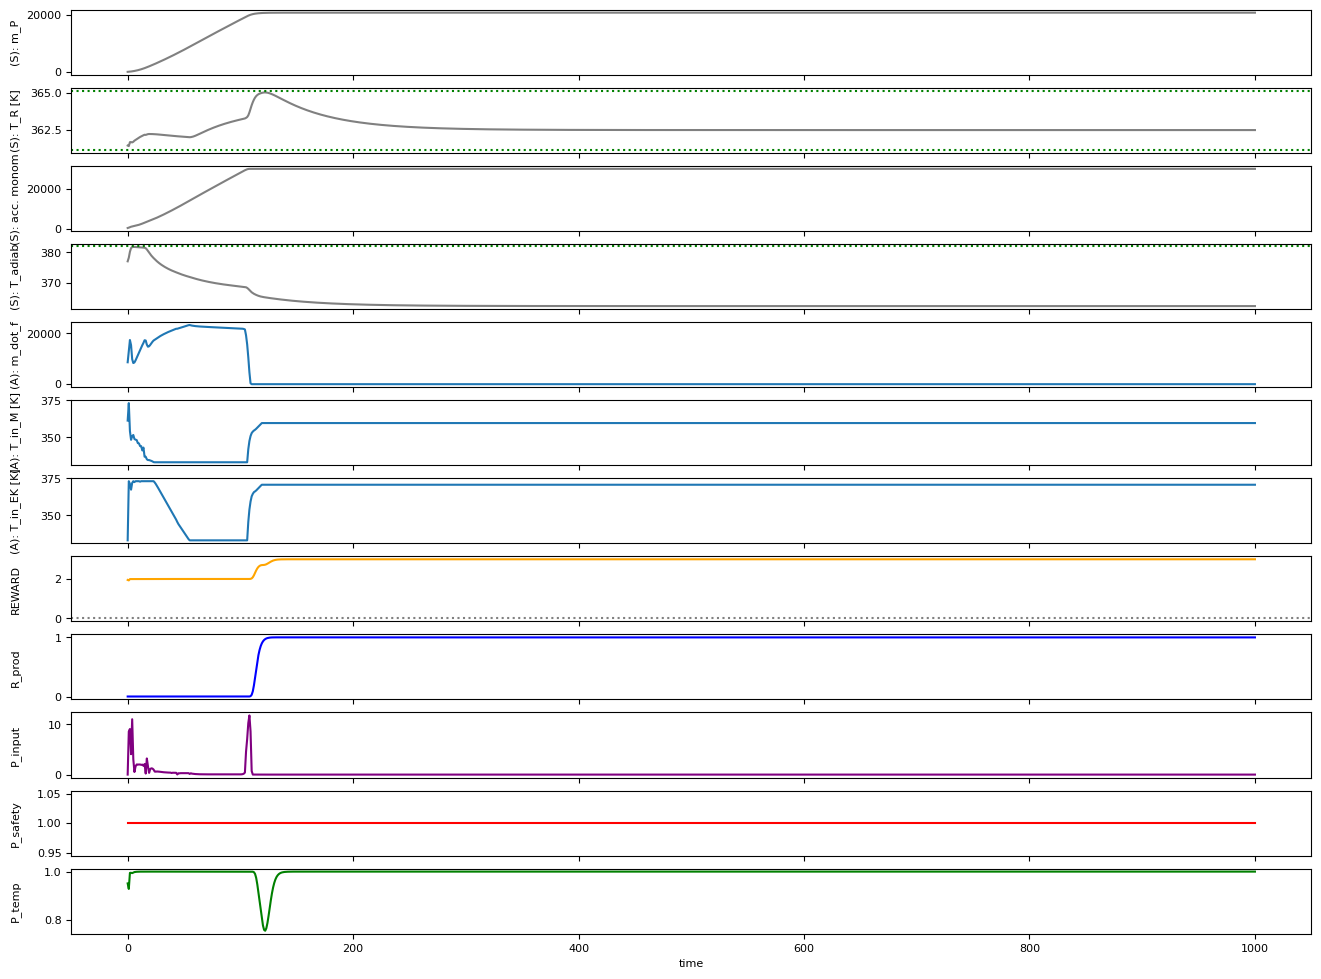

[None]

In [ ]:
model = template_model()
estimator = do_mpc.estimator.StateFeedback(model)
mpc = template_mpc(model)
simulator = template_simulator(model)

obs, info = venv.reset()
reward_list = []
terminated = False
truncated = False
while not (terminated or truncated):
    state = construct_state_dict(venv.denormalize_obs(obs)[0])
    if len(reward_list) < 120:
        _, act = mpc_rollout(state, simulator, mpc, estimator, 1)
    observation, reward, terminated, truncated, info  = venv.step(act)
    obs = observation
    
    reward_list.append(reward)
venv.render()

In [ ]:
state = {'m_W': 13638.676248779228,
 'm_A': 1023.9034781796272,
 'm_P': 7143.875975080995,
 'T_R': 363.9654724934564,
 'T_S': 356.6514915346367,
 'Tout_M': 358.44751957631786,
 'T_EK': 362.4004261516066,
 'Tout_AWT': 362.46388125084377,
 'accum_monom': 11226.955702039853}

In [ ]:
obs, _ = venv.reset()
state = construct_state_dict(venv.denormalize_obs(obs)[0])

In [ ]:
model = template_model()
estimator = do_mpc.estimator.StateFeedback(model)
mpc = template_mpc(model)
simulator = template_simulator(model)
mpc_rollout(state, simulator, mpc, estimator, 1)

0
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    32770
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     9669

Total number of variables............................:     8100
                     variables with only lower bounds:     2052
                variables with lower and upper bounds:     4644
                     variables with only upper bounds:      684
Total number of equality constraints.................:     7210
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.4401359e+05 4.09e+01 4.45e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+0

([{'m_W': array([13638.67624878]),
   'm_A': array([864.81804705]),
   'm_P': array([7302.96140621]),
   'T_R': array([364.55201968]),
   'T_S': array([357.04372468]),
   'Tout_M': array([346.40817932]),
   'T_EK': array([345.6598858]),
   'Tout_AWT': array([344.95342046]),
   'accum_monom': array([11226.95570203])}],
 array([[-8.96352158e-07,  3.33149997e+02,  3.33149997e+02]]))

In [ ]:
def policy_rollout(init_state, length=10):
    _venv = MyVectorEnvNormObs(DummyVectorEnv([lambda: env]))
    policy.eval()
    obs, info = _venv.reset(init_state=init_state)
    states = []
    for i in range(length):
        states.append(_venv.denormalize_obs(obs).squeeze())
        batch = Batch(obs=torch.from_numpy(obs).to(device), info=info)
        with torch.no_grad():
            result = policy(batch)
        act = result.act.cpu().numpy()
        act = policy.map_action(act)
        observation, _, _, _, info  = _venv.step(act)
        obs = observation
        if i == 0:
            action = act
    return np.array(states), action

In [ ]:
def check_constraints(states):
    return all(abs(states[:, 3] - env.desired_temp) <= 2) and all(states[:, -1] <= 382.15)

def cede_ctrl(state, simulator, mpc, estimator, length=10):
    x0 = deepcopy(state)
    policy_states, policy_action = policy_rollout(x0, length)

    if check_constraints(policy_states):
        print("ploicy: ", policy_action)
        return policy_action
    
    _, mpc_action = mpc_rollout(x0, simulator, mpc, estimator, 1)
    print("mpc: ", mpc_action)
    return mpc_action

In [ ]:
model = template_model()
estimator = do_mpc.estimator.StateFeedback(model)
mpc = template_mpc(model)
simulator = template_simulator(model)

obs, info = venv.reset()
reward_list = []
terminated = False
truncated = False
while not (terminated or truncated):
    batch = Batch(obs=torch.from_numpy(obs).to(device), info=info)
    state = construct_state_dict(venv.denormalize_obs(obs)[0])
    act = cede_ctrl(state, simulator, mpc, estimator)
    observation, reward, terminated, truncated, info  = venv.step(act)
    obs = observation
    print("step")
    
    reward_list.append(reward)
venv.render()

ploicy:  [[4796.4136   369.92715  367.90707]]
step
ploicy:  [[4796.4136   369.92715  367.90707]]
step
ploicy:  [[4796.4136   369.92715  367.90707]]
step
ploicy:  [[4796.4136   369.92715  367.90707]]
step
ploicy:  [[4796.4136   369.92715  367.90707]]
step
0
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    32770
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     9669

Total number of variables............................:     8100
                     variables with only lower bounds:     2052
                variables with lower and upper bounds:     4644
                     variables with only upper bounds:      684
Total number of equality constraints.................:     7210
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with

CasADi - 2024-03-05 16:04:17 WARNING("KeyboardInterruptException") [.../casadi/interfaces/ipopt/ipopt_nlp.cpp:132]


SystemError: <built-in function Function_call> returned a result with an exception set

In [ ]:
state

{'m_W': 13638.676248779228,
 'm_A': 1023.9034781796272,
 'm_P': 7143.875975080995,
 'T_R': 363.9654724934564,
 'T_S': 356.6514915346367,
 'Tout_M': 358.44751957631786,
 'T_EK': 362.4004261516066,
 'Tout_AWT': 362.46388125084377,
 'accum_monom': 11226.955702039853}

In [ ]:
len(reward_list)

5

In [ ]:
# mpc_graphics = do_mpc.graphics.Graphics(mpc.data)

In [ ]:
# from matplotlib import rcParams
# rcParams['axes.grid'] = True
# rcParams['font.size'] = 18

In [ ]:
# %%capture
# fig, ax = plt.subplots(5, sharex=True, figsize=(16,12))
# plt.ion()
# # Configure plot:
# mpc_graphics.add_line(var_type='_x', var_name='T_R', axis=ax[0])
# mpc_graphics.add_line(var_type='_x', var_name='accum_monom', axis=ax[1])
# mpc_graphics.add_line(var_type='_u', var_name='m_dot_f', axis=ax[2])
# mpc_graphics.add_line(var_type='_u', var_name='T_in_M', axis=ax[3])
# mpc_graphics.add_line(var_type='_u', var_name='T_in_EK', axis=ax[4])

# ax[0].set_ylabel('T_R [K]')
# ax[1].set_ylabel('acc. monom')
# ax[2].set_ylabel('m_dot_f')
# ax[3].set_ylabel('T_in_M [K]')
# ax[4].set_ylabel('T_in_EK [K]')
# ax[4].set_xlabel('time')

# fig.align_ylabels()

In [ ]:
# from matplotlib.animation import FuncAnimation, ImageMagickWriter

In [ ]:
# def update(t_ind):
#     print('Writing frame: {}.'.format(t_ind), end='\r')
#     mpc_graphics.plot_results(t_ind=t_ind)
#     mpc_graphics.plot_predictions(t_ind=t_ind)
#     mpc_graphics.reset_axes()
#     lines = mpc_graphics.result_lines.full
#     return lines

# n_steps = mpc.data['_time'].shape[0]


# anim = FuncAnimation(fig, update, frames=n_steps, blit=True)

# gif_writer = ImageMagickWriter(fps=5)
# anim.save('anim_poly_batch.gif', writer=gif_writer)

In [ ]:
%%capture
for k in range(150):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

In [ ]:
m_dot_f = mpc.data["_u", "m_dot_f"]
T_in_M = mpc.data["_u", "T_in_M"]  
T_in_EK = mpc.data["_u", "T_in_EK"]

In [ ]:
actions = np.array([m_dot_f, T_in_M, T_in_EK]).T.squeeze()

In [ ]:
actions

array([[ 1.08583952e+04,  3.47422800e+02,  3.33149997e+02],
       [ 1.33748769e+04,  3.73150004e+02,  3.73150004e+02],
       [ 1.69404272e+04,  3.56825438e+02,  3.73021253e+02],
       [ 1.41964617e+04,  3.49061032e+02,  3.70522608e+02],
       [ 9.19707126e+03,  3.50036279e+02,  3.72564592e+02],
       [ 8.11026625e+03,  3.51455126e+02,  3.73150004e+02],
       [ 8.52761866e+03,  3.48989133e+02,  3.72820466e+02],
       [ 9.39841798e+03,  3.48299614e+02,  3.73150004e+02],
       [ 1.04191331e+04,  3.48172851e+02,  3.73150004e+02],
       [ 1.14204285e+04,  3.46007485e+02,  3.73150004e+02],
       [ 1.24190611e+04,  3.45927478e+02,  3.73150004e+02],
       [ 1.34280931e+04,  3.44076319e+02,  3.72637683e+02],
       [ 1.44017707e+04,  3.43943099e+02,  3.73150004e+02],
       [ 1.53878965e+04,  3.41121024e+02,  3.73150004e+02],
       [ 1.62495083e+04,  3.42954947e+02,  3.73150004e+02],
       [ 1.72915643e+04,  3.36951621e+02,  3.73150004e+02],
       [ 1.71471172e+04,  3.36610089e+02

In [ ]:
new_actions = np.repeat([[0, 362.40, 373.14]], 850, 0)

In [ ]:
new_actions.shape

(850, 3)

In [ ]:
actions = np.concatenate([actions, new_actions])

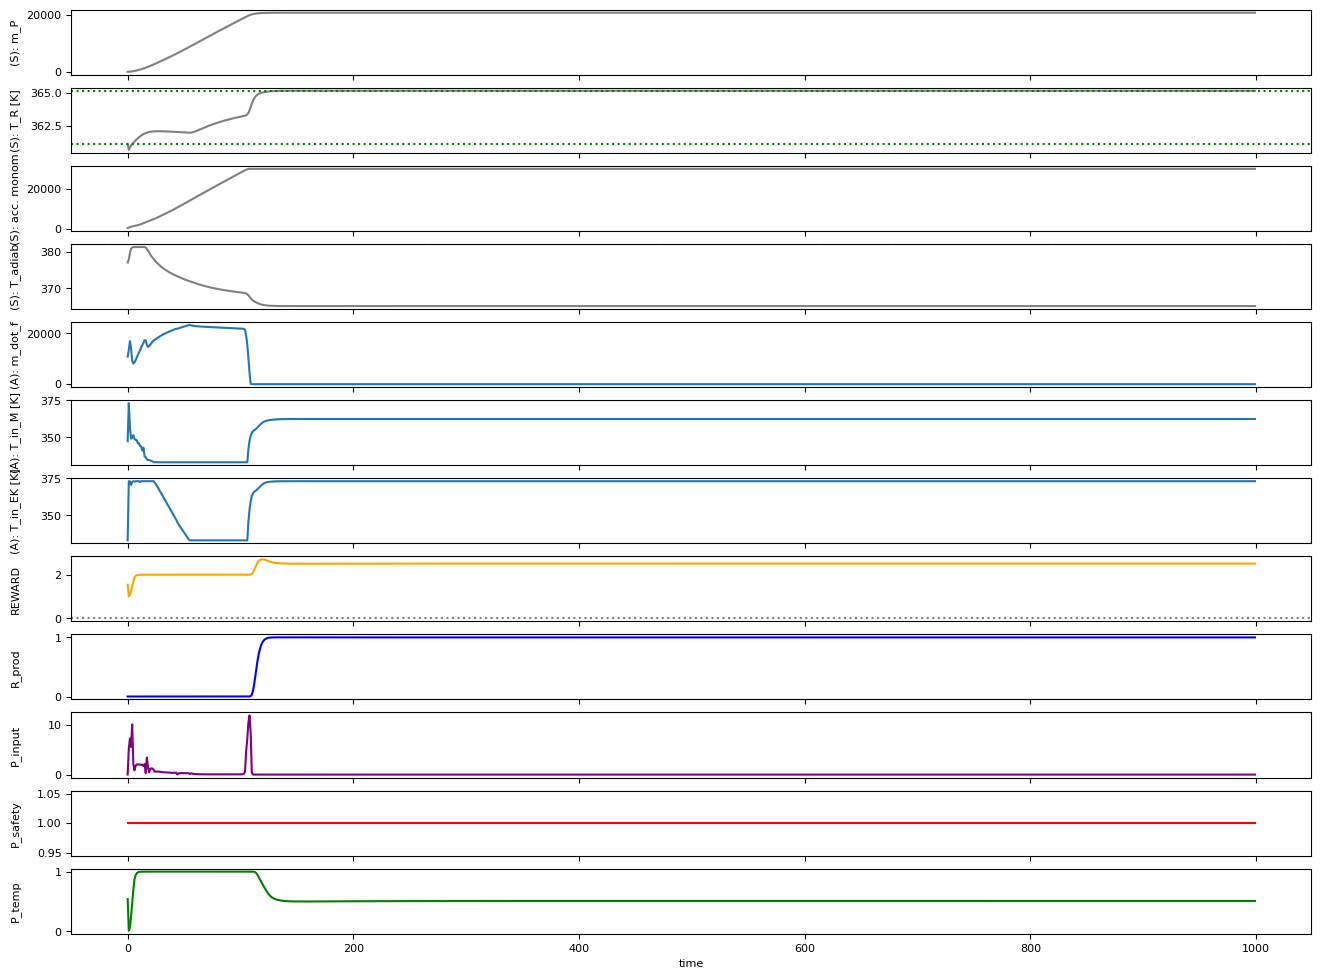

[None]

In [ ]:
# create tianshou buffer
buffer = ReplayBuffer(size=len(actions))

obs, info = venv.reset()
reward_list = []
for i in range(len(actions)):
    observation, reward, terminated, truncated, info  = venv.step(np.expand_dims(actions[i], 0))
    # save to buffer
    buffer.add(Batch(obs=obs, act=actions[i], rew=reward, terminated=terminated, truncated=truncated, obs_next=observation))
    obs = observation
    reward_list.append(reward)
venv.render()

In [ ]:
sum(reward_list)

array([1948.26093411])